In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install pytorch_lightning
!pip install tueplots

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 59.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 50.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 46.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-

In [ ]:
!apt-get update
!apt-get install -y texlive-latex-extra texlive-fonts-recommended dvipng cm-super


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/dinopl-main')


In [ ]:
%load_ext autoreload
%autoreload 2
import os
import torch
import wandb
import matplotlib
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
from tqdm import tqdm
import numpy as np
from itertools import takewhile, islice


from typing import Dict, Iterable, Any
from wandb.apis.public import Run
Runs = Iterable[Run]
api = wandb.Api(timeout=19)

import dinopl.utils as U

#sns.set_theme()
#sns.set_theme(context='paper', font_scale=0.5)
#sns.set_style()


from tueplots import bundles, axes, figsizes, fonts, fontsizes
tue_params = bundles.icml2022(usetex=True, family='sans-serif') #sans-serif
tue_params.update(bundles.fontsizes.icml2022(default_smaller=1))
tue_params.update(figsizes.icml2022_half(tight_layout=True, pad_inches=0))
tue_params.update(axes.lines(base_width=0.25))
tue_params.update(axes.legend(frameon=True, fancybox=False))
#sns.set_style(style='darkgrid', rc=tue_params)
plt.rcParams.update(tue_params)
plt.style.use('seaborn-v0_8-darkgrid')
matplotlib.rcParams['text.latex.preamble']= matplotlib.rcParams['text.latex.preamble'] + r" \usepackage{amsmath, amssymb}"


# Use latest verion of matplotlib-inline to avoid jupyter notebook bug:
#https://github.com/matplotlib/matplotlib/issues/9217
#https://github.com/ipython/ipykernel/issues/267

In [ ]:
from cycler import cycler
from matplotlib import cm
from matplotlib.colors import Normalize, BoundaryNorm, Colormap

def get_from_config(run, key:str):
    if not key.startswith('dino_config.'):
        return run.config[key]
    if key.startswith('dino_config.'):
        key = key[len('dino_config.'):]
        return run.config['dino_config'][key]

def plot_agg(runs:Runs, group_by:str, metric:str, xmetric:str=None, labels:list=None,
                group_keys=None, reverse_sort=False, summary_type='max', filter:dict={},
                colors:Colormap=None, alpha=0.15, lw=None, zorder=None, agg='std',
                scan_step:int=None, max_step=None, ema_alpha:float=0., ax=None
                ):
    if ax is None:
        fig, ax = plt.subplots(1, 1)

    groups:Dict[Any, Iterable[Run]] = {}
    for run in runs:
        #if any([run.config[name] != value for name, value in filter.items()]):
        #    continue

        if any([get_from_config(run, name) != value for name, value in filter.items()]):
            continue

        group_val = get_from_config(run, group_by)
        #if group_by.startswith('dino_config.'):
        #    group_val = run.config['dino_config'][group_by[len('dino_config.'):]]
        #else:
        #    group_val = run.config[group_by]

        # group by by config
        if group_val not in groups.keys():
            groups[group_val] = []
        groups[group_val].append(run)

    if group_keys is None:
        group_keys = list(sorted(groups.keys(), reverse=reverse_sort))

    # make labels
    if labels is None:
        labels = group_keys
    if not isinstance(labels, list):
        labels = [labels] * len(group_keys)
    if len(labels) != len(group_keys):
        raise ValueError('Provided labels are not of same length as group keys.')

    # make colors
    if colors is None: # set default colorcycle
        colors = list(cm.tab10.colors)

    if isinstance(colors, (tuple, str, float)):
        colors = [colors] * len(group_keys)
    elif isinstance(colors, Iterable):
        cmapper = cycler(colors=colors)
        colors = [elem['c'] for _, elem in zip(group_keys, cycler(c=colors))]
    elif isinstance(colors, Colormap):
        color_keys = group_keys
        if not isinstance(color_keys[0], (float, int)):
            color_keys = range(len(group_keys))
        #norm = Normalize(group_keys)              # linearly
        #norm = BoundaryNorm(sorted(group_keys), colors.N, extend='max')    # discrete sorted numeric values
        norm = BoundaryNorm(sorted(color_keys), colors.N, extend='max')    # discrete sorted numeric values
        cmapper = cm.ScalarMappable(norm=norm, cmap=colors)
        colors = map(cmapper.to_rgba, color_keys)

    # iterate through groups
    summary = dict()
    n_aggregates = dict()
    for group_key, label, color in tqdm(list(zip(group_keys, labels, colors))):
        hists, hists_xs = [], [] # gather histories of runs in group
        for run in groups[group_key]:
            hist:pd.DataFrame = run.history(keys=[metric]+([] if xmetric is None else [xmetric]))

            if scan_step is not None:
                scan = run.scan_history(keys=[metric, 'trainer/global_step']+([] if xmetric is None else [xmetric]))
                if hist.empty:
                    continue
                hist = pd.DataFrame(islice(scan, 0, max_step, scan_step)) # run.summary['trainer/global_step'] // scan_samples
                if xmetric is not None:
                    hist[xmetric] = hist['trainer/global_step'] * hist[xmetric].iloc[-1] / hist['trainer/global_step'].iloc[-1]

                # sort values and interpolate xmetric
                hist = hist.sort_values('trainer/global_step', axis='index')

            if hist.empty:
                continue

            #hist[metric] = hist[metric].rolling(3).median()
            if 1 >= ema_alpha and ema_alpha > 0: # ema smoothing for all but initial entries
                hist[metric] = hist[metric].ewm(alpha=ema_alpha).mean()

            if metric in hist.keys() and not hist[metric].empty:
                hists.append(hist[metric])
            if xmetric in hist.keys() and not hist[xmetric].empty:
                hists_xs.append(hist[xmetric])

        # make one dataframe for this group
        if len(hists) == 0:
            print(f'Run {run.name} in {group_key} has no history with metric \'{metric}\'.')
            continue
        n_aggregates[f'{label}'] = len(hists)

        hists = pd.concat(hists, axis='columns')
        if len(hists_xs) > 0:
            hists.index = max(hists_xs, key=len) # use longest xmetric as index

        # aggregate metric accross runs in group
        hists_mean = hists.mean(axis=1, skipna=True)
        hists_std = hists.std(axis=1, skipna=True).fillna(0.0)
        hists_min = hists.min(axis=1, skipna=True).fillna(0.0)
        hists_max = hists.max(axis=1, skipna=True).fillna(0.0)
        ax.plot(hists.index, hists_mean, label=label, lw=lw, color=color, zorder=zorder)

        if agg is None:
            ax.plot(hists.index, hists, color=color, alpha=alpha, zorder=zorder)
        if agg == 'std':
            ax.fill_between(hists.index, hists_mean - hists_std, hists_mean + hists_std, color=color, alpha=alpha, zorder=zorder)
        if agg == 'minmax':
            ax.fill_between(hists.index, hists_min, hists_max, color=color, alpha=alpha, zorder=zorder)

        # summarize metric within run but ignore first ones
        if summary_type == 'max':
            hists_best = hists[1:].max(axis=0, skipna=True)
        elif summary_type == 'min':
            hists_best = hists[1:].min(axis=0, skipna=True)
        elif summary_type == 'last':
            hists_best = hists[1:].iloc[-1]
        else:
            raise ValueError('Unkown key for summary.')

        summary[group_key] = {'mean':hists_best.mean(skipna=True),
                                'std':hists_best.std(skipna=True),
                                'min':hists_best.min(skipna=True),
                                'max':hists_best.max(skipna=True),
                                'color':color}

    print(f'aggregated: {n_aggregates}')
    return pd.DataFrame.from_dict(summary, orient='index')

In [ ]:
run = api.run('safelix/DINO/runs/1jexlm4j')
hist = run.history(keys=['probe/student', 'probe/teacher'])
baseline = pd.concat((hist['probe/student'], hist['probe/teacher'])).mean()

In [ ]:
baseline

0.3825000002980232

### Investigating DINO

#### Dissecting DINO

100%|██████████| 5/5 [00:01<00:00,  2.78it/s]


aggregated: {'0: original DINO': 1, '1: freeze teacher': 1, '2: no multi-crop': 1, '3: no augmentations': 1, '4: no asymmetries': 1}


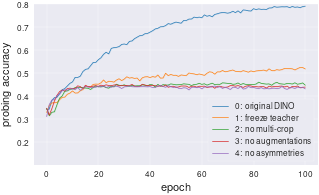

In [ ]:
from matplotlib import cm

def plot_dissect(runs, labels=None, title=None, ax=None):
    if ax is None:
        f, ax = plt.subplots(1,1)

    plot_agg(runs, 'from_json', metric='probe/student', labels=labels, reverse_sort=False, ax=ax) #colors=cm.tab10,

    #ax.set_ylim([-0.05, 0.85])
    #ax.set_ylim([0.08, 0.82])
    #ax.set_ylim([0.10, 0.79])
    ax.set_ylim([0.101, 0.80])
    ax.set_xlabel('epoch')
    ax.set_ylabel('probing accuracy')
    ax.yaxis.get_major_locator().set_params(nbins=7)
    ax.xaxis.get_major_locator().set_params(nbins=7)

nrows, ncols = 1, 1
with plt.rc_context(figsizes.icml2022_half(nrows=nrows, ncols=ncols)):
    runs_resnet = [api.run('safelix/DINO/runs/d0xtiibo')] + list(api.sweep('safelix/DINO/sweeps/94gfni7e').runs)

    labels =  ['0: original DINO', '1: freeze teacher', '2: no multi-crop', '3: no augmentations', '4: no asymmetries']


    f, ax = plt.subplots(nrows, ncols, sharex=True, sharey=True)

    plot_dissect(runs_resnet, labels=labels, title='ResNet18', ax=ax)

    ax.legend(loc='lower right', frameon=True)
    #ax[1].legend(bbox_to_anchor=(1, 0.5), loc='center left')
    #ax[1].legend(*ax[0].get_legend_handles_labels(), bbox_to_anchor=(1, 0.5), loc='center left')
    #ax[1].legend(*ax[0].get_legend_handles_labels(), frameon=True, borderpad=0)

    plt.savefig('dino_dissect_resnet.pdf')
    plt.show()

100%|██████████| 5/5 [00:01<00:00,  2.66it/s]


aggregated: {'0: original DINO': 1, '1: freeze teacher': 1, '2: no multi-crop': 1, '3: no augmentations': 1, '4: no asymmetries': 1}


100%|██████████| 5/5 [00:05<00:00,  1.20s/it]


aggregated: {'configs/cifar10_dino.json': 1, 'configs/cifar10_dino_dissect1.json': 1, 'configs/cifar10_dino_dissect2.json': 1, 'configs/cifar10_dino_dissect3.json': 1, 'configs/cifar10_dino_dissect4.json': 1}


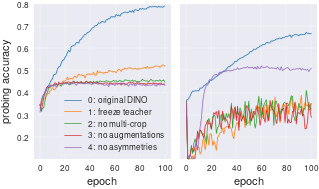

In [ ]:
nrows, ncols = 1, 2
with plt.rc_context(figsizes.icml2022_half(nrows=nrows, ncols=ncols, height_to_width_ratio=1.2)):
    runs_resnet = [api.run('safelix/DINO/runs/d0xtiibo')] + list(api.sweep('safelix/DINO/sweeps/94gfni7e').runs)
    runs_vgg11 = list(api.sweep('safelix/DINO/sweeps/8w7sh4co').runs)

    labels =  ['0: original DINO', '1: freeze teacher', '2: no multi-crop', '3: no augmentations', '4: no asymmetries']


    f, ax = plt.subplots(nrows, ncols, sharex=True, sharey=True)

    plot_dissect(runs_resnet, labels=labels, title='ResNet18', ax=ax[0])
    plot_dissect(runs_vgg11, labels=None, title='VGG11', ax=ax[1])

    ax[1].set_ylabel('')

    ax[0].legend(loc='lower right', frameon=True)
    #ax[1].legend(bbox_to_anchor=(1, 0.5), loc='center left')
    #ax[1].legend(*ax[0].get_legend_handles_labels(), bbox_to_anchor=(1, 0.5), loc='center left')
    #ax[1].legend(*ax[0].get_legend_handles_labels(), frameon=True, borderpad=0)


    plt.savefig('dino_dissect.pdf')
    plt.show()

#### Investigating Normalization Layers

100%|██████████| 5/5 [00:13<00:00,  2.77s/it]


aggregated: {'BatchNorm': 3, 'InstanceNorm': 3, 'GroupNorm8': 3, 'LayerNorm': 3, 'Identity': 3}


100%|██████████| 5/5 [00:10<00:00,  2.15s/it]


aggregated: {'BatchNorm': 2, 'InstanceNorm': 3, 'GroupNorm8': 3, 'LayerNorm': 3, 'Identity': 3}


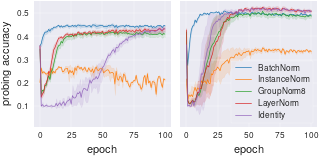

In [ ]:
runs = api.sweep('safelix/DINO/sweeps/mgv2qemx').runs   # NormLayer
norm_names = ['BatchNorm', 'InstanceNorm', 'GroupNorm8', 'LayerNorm', 'Identity']


nrows, ncols = 1, 2
with plt.rc_context(figsizes.icml2022_half(nrows=nrows, ncols=ncols, height_to_width_ratio=1)):

    f, ax = plt.subplots(nrows, ncols, sharex=True, sharey=True)

    plot_agg(runs, group_by='enc_norm_layer', group_keys=norm_names, metric='probe/student', filter={'enc':'resnet18'}, ax=ax[0])
    plot_agg(runs, group_by='enc_norm_layer', group_keys=norm_names, metric='probe/student', filter={'enc':'vgg11'}, ax=ax[1])

    ax[0].set_xlabel('epoch')
    ax[1].set_xlabel('epoch')
    ax[0].set_ylabel('probing accuracy')
    ax[0].set_ylim(0.01, 0.55)
    ax[1].legend(frameon=True)
    plt.savefig('init-distill-normlayer_v2.pdf')
    plt.show()

#### Investigating MSE Loss

100%|██████████| 20/20 [00:42<00:00,  2.10s/it]


aggregated: {'1e-16': 3, '1e-15': 3, '1e-14': 3, '1e-13': 3, '1e-12': 3, '1e-11': 2, '1e-10': 4, '1e-09': 3, '1e-08': 3, '1e-07': 3, '1e-06': 3, '1e-05': 3, '0.0001': 3, '0.001': 3, '0.01': 3, '0.1': 3, '1': 3, '10': 3, '100': 3, '1000': 3}


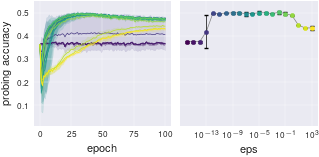

In [ ]:
from matplotlib import cm

epsilons = [10**x for x in range(-16, 4)]

nrows, ncols = 1, 2
def plot_neighborhood(runs):

    f, ax = plt.subplots(nrows, ncols, sharex=False, sharey=True)

    summary = plot_agg(runs, group_by='t_init_eps', colors=cm.viridis, metric='probe/student', ax=ax[0]) # deprecated t_init_eps

    ax[1].plot(summary.index, summary['mean'], color='gray', linestyle='-')
    for idx, elem in summary.iterrows():
        ax[1].errorbar(idx, elem['mean'], elem['std'], capsize=1.5, ecolor='k')
        ax[1].scatter(idx, elem['mean'], color=elem['color'], s=10, zorder=2)

    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('probing accuracy')
    ax[0].set_ylim(0.01, 0.55)

    ax[1].set_xlabel('eps')
    ax[1].set_xscale('log', base=10)

    return summary

    #ax[1].legend(frameon=True)

with plt.rc_context(figsizes.icml2022_half(nrows=nrows, ncols=ncols, height_to_width_ratio=1)):
    runs = api.sweep('safelix/DINO/sweeps/b3wnyrnc').runs # Adam: MSE
    summary_float32 = plot_neighborhood(runs)
    plt.savefig('init-distill-neighborhood-mse.pdf')
    plt.show()

100%|██████████| 20/20 [00:39<00:00,  1.99s/it]


aggregated: {'1.0000000000000001e-29': 3, '9.999999999999999e-29': 3, '1e-27': 3, '9.999999999999999e-27': 3, '1e-25': 3, '1e-24': 3, '1.0000000000000001e-23': 3, '1e-22': 3, '1e-21': 3, '1e-20': 3, '1e-19': 3, '1e-18': 3, '1e-17': 3, '1e-16': 3, '1e-15': 3, '1e-14': 3, '1e-13': 3, '1e-12': 3, '1e-11': 3, '1e-10': 3}


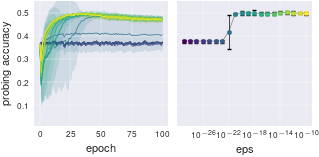

In [ ]:
with plt.rc_context(figsizes.icml2022_half(nrows=nrows, ncols=ncols, height_to_width_ratio=1)):
    runs = api.sweep('safelix/DINO/sweeps/qe0q926p').runs # Adam: MSE float64
    summary_float64 = plot_neighborhood(runs)
    plt.savefig('init-distill-neighborhood-mse-float64.pdf')
    plt.show()

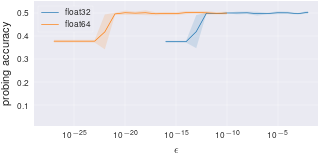

In [ ]:
#with plt.rc_context(figsizes.icml2022_half(nrows=nrows, ncols=ncols, height_to_width_ratio=1)):

with plt.rc_context(figsizes.icml2022_half(nrows=1, ncols=1, height_to_width_ratio=0.5)):

    summary_float32 = summary_float32[summary_float32.index <= 1e-2]
    summary_float64 = summary_float64[summary_float64.index >= 1e-28]

    f, ax = plt.subplots(1, 1, sharex=True, sharey=True)
    ax.plot(summary_float32.index, summary_float32['mean'], label='float32')
    ax.fill_between(summary_float32.index, summary_float32['mean'] - summary_float32['std'],
                        summary_float32['mean'] + summary_float32['std'], alpha=0.15)

    ax.fill_between(summary_float64.index, summary_float64['mean'] - summary_float64['std'],
                        summary_float64['mean'] + summary_float64['std'], alpha=0.15)
    ax.plot(summary_float64.index, summary_float64['mean'], label='float64')


    #ax.hlines(baseline, 0, 1, colors='gray', linestyles='--', label='input')
    #ax.hlines(baseline_resnet, 0, 1, color='C0', linestyles='--')
    #ax.hlines(baseline_vgg, 0, 1,  color='C1', linestyles='--')
    #ax.hlines(0, 0, 0, colors='gray', linestyles='--', label='teachers')

    ax.set_ylabel('probing accuracy')
    ax.set_xlabel('$\\epsilon$')
    ax.set_xscale('log', base=10)
    #ax.set_ylim(0.275, 0.575)
    ax.set_ylim(0.01, 0.55)
    ax.set_xlim(1e-29, 1e-1)
    ax.set_xticks([10**i for i in range(-25, 0, 5)])



    plt.legend(frameon=True)
    plt.savefig('init-mse-numerical-analysis.pdf')
    plt.show()

#### Investigating the Projection Head

In [ ]:
matplotlib.rcParams['text.latex.preamble']  + r'\usepackage{calc}'

'\\usepackage{times} \\renewcommand{\\familydefault}{\\sfdefault} \\usepackage{sansmath} \\sansmath \\usepackage{amsmath, amssymb}\\usepackage{calc}'

100%|██████████| 6/6 [00:08<00:00,  1.47s/it]


aggregated: {'-/-/-/-/l/fn': 2, '-/lb/-/-/l/-': 2, '-/lb/-/-/l/fn': 3, '-/lb/fn/-/l/fn': 3, '-/lb/fn/wn/l/-': 3, 'wn/lb/-/wn/l/-': 2}


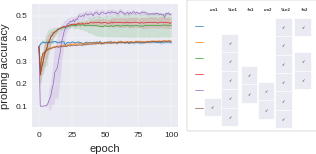

In [ ]:
plot_params = figsizes.icml2022_half(nrows=1, ncols=2, height_to_width_ratio=1)
plot_params['text.usetex'] = False
#plot_params['text.latex.preamble'] = matplotlib.rcParams['text.latex.preamble'] + r" \usepackage{xcolor}"
#plot_params['text.latex.preamble'] = matplotlib.rcParams['text.latex.preamble'] + r" \usepackage{calc}" + r' \usepackage{xcolor}'

#plot_params = plt.rcParamsDefault
@plt.rc_context(plot_params)
def plot_bottleneck(runs, enc, cfgs, name=''):

    f, (ax, legax) = plt.subplots(nrows=1, ncols=2, width_ratios=[0.7, 0.3])
    plot_agg(runs, group_by='l2bot_cfg', metric='probe/student', filter={'enc':enc}, ax=ax)
    ax.set_ylabel('probing accuracy')
    ax.set_xlabel('epoch')
    ax.set_ylim(0.01, 0.55)


    # make the legend table
    ax.plot([0], [0], visible=False, label='empty')
    handles, labels = ax.get_legend_handles_labels()
    empty = handles[-1]
    titles = ['wn1', 'lin1', 'fn1', 'wn2', 'lin2', 'fn2']

    nrow, ncol = len(cfgs), len(titles)
    cells = nrow*ncol*[None]
    marks = nrow*ncol*[None]
    for row in range(nrow):
        for col in range(ncol):
            idx = row + nrow*col

            cells[idx] = ''  # make cells
            if row>=1 and labels[row-1].split('/')[col] != '-':
                cells[idx] = '$\checkmark$'

            marks[idx] = empty  # make marks
            if col == 0 and row>=1: # ignore header
                marks[idx] = handles[row-1]

            if row==0:  # make titles
                cells[idx] = titles[col]
                #cells[idx] = r'\textbf{\texttt{' + cells[idx] + r'}}'
                #cells[idx] = r'\smash{' + cells[idx] + r'}'
                #cells[idx] = r'{\bf\ttfamily\smash{' + titles[col] + r'}}'

            #cells[idx] = r'\makebox[4em]{' + cells[idx] + r'}'
            #cells[idx] = r'\framebox[2em]{' + cells[idx] + r'}'
            #cells[idx] = r'\parbox[c][3em]{3em}{' + cells[idx] + r'}'
            #cells[idx] = '\centering' + cells[idx]


    legax.axis('off')
    #legend = legax.legend(marks, cells, ncol=ncol, columnspacing=-1.4, labelspacing=2.9, handletextpad=1.7, mode=None,
    #                    loc='center', fontsize=3, frameon=True, facecolor='w', edgecolor='black', borderpad=0, alignment='center', framealpha=0)

    legend = legax.legend(marks, cells, ncol=ncol, loc='center', alignment='center', mode=None,
                            fontsize=3, columnspacing=-1.4, labelspacing=2.9, handletextpad=1.7,
                            frameon=True, fancybox=True, facecolor='w', edgecolor='gray', borderpad=2)

    for text in legend.texts:
        if 'checkmark' in text.get_text():
            text.set_backgroundcolor(ax.get_facecolor())
            #text.get_bbox_patch().set_width(2)
            #text.get_bbox_patch().set_height(2)
            #text.set_bbox(dict(facecolor='red', alpha=0.5))
            #text.get_bbox_patch().set_bounds(0, 0, 10, 10)
            marktext = text
            pass
        if text.get_text() in titles:
            text.set_fontweight('bold')
            text.set_family('monospace')
            text.set(fontsize=3, linespacing=0.2)

    return legend

runs = api.sweep('safelix/DINO/sweeps/bqs03n6g').runs # L2Bottleneck
cfgs = ['-/lb/fn/wn/l/-', 'wn/lb/-/wn/l/-', '-/lb/fn/-/l/fn', '-/lb/-/-/l/fn', '-/lb/-/-/l/-', '-/-/-/-/l/fn', '-/-/-/-/l/-']
text = plot_bottleneck(runs, enc='vgg11', cfgs=cfgs)
plt.savefig('init-distill-l2bot.pdf')
plt.show()


100%|██████████| 6/6 [00:21<00:00,  3.56s/it]


aggregated: {'-/lb/fn/wn/l/-': 3, 'wn/lb/-/wn/l/-': 3, '-/lb/fn/-/l/fn': 3, '-/lb/-/-/l/fn': 3, '-/lb/-/-/l/-': 3, '-/-/-/-/l/fn': 2}


100%|██████████| 6/6 [00:12<00:00,  2.14s/it]


aggregated: {'-/lb/fn/wn/l/-': 3, 'wn/lb/-/wn/l/-': 2, '-/lb/fn/-/l/fn': 3, '-/lb/-/-/l/fn': 3, '-/lb/-/-/l/-': 2, '-/-/-/-/l/fn': 2}


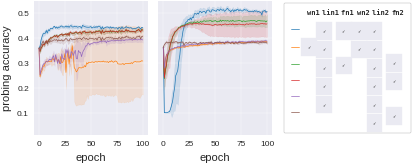

In [ ]:
plot_params = {}
#plot_params = figsizes.icml2022_half(nrows=1, ncols=2, height_to_width_ratio=1)
plot_params = figsizes.icml2022_half(nrows=1, ncols=1)
plot_params['text.usetex'] = False
#plot_params['text.latex.preamble'] = matplotlib.rcParams['text.latex.preamble'] + r" \usepackage{xcolor}"
#plot_params['text.latex.preamble'] = matplotlib.rcParams['text.latex.preamble'] + r" \usepackage{calc}" + r' \usepackage{xcolor}'

#plot_params = plt.rcParamsDefault
@plt.rc_context(plot_params)
def plot_bottleneck(runs, cfgs, agg='std'):

    #f, (ax, ax2, legax) = plt.subplots(nrows=1, ncols=3, width_ratios=[0.3, 0.3, 0.4], figsize=(4.2, 1.7), sharex=True, sharey=True)
    f, (ax, ax2, legax) = plt.subplots(nrows=1, ncols=3, width_ratios=[1/3, 1/3, 1/3], figsize=(4.2, 1.7), sharex=True, sharey=True)
    plot_agg(runs, group_by='l2bot_cfg', group_keys=cfgs, metric='probe/student', agg=agg, filter={'enc':'resnet18'}, ax=ax)
    plot_agg(runs, group_by='l2bot_cfg', group_keys=cfgs, metric='probe/student', agg=agg, filter={'enc':'vgg11'}, ax=ax2)
    ax.set_ylabel('probing accuracy')
    ax.set_xlabel('epoch')
    ax2.set_xlabel('epoch')
    ax.set_ylim(0.01, 0.55)
    ax.set_xticks([0, 25, 50, 75, 100])
    #ax.set_xticks([0, 25, 50, 75, 100], minor=True)


    # make the legend table
    ax.plot([0], [0], visible=False, label='empty')
    handles, labels = ax.get_legend_handles_labels()
    empty = handles[-1]
    titles = ['wn1 ', 'lin1 ', 'fn1 ', 'wn2 ', 'lin2 ', 'fn2']

    nrow, ncol = len(cfgs)+1, len(titles)
    cells = nrow*ncol*[None]
    marks = nrow*ncol*[None]
    for row in range(nrow):
        for col in range(ncol):
            idx = row + nrow*col

            cells[idx] = ''  # make cells
            if row>=1 and labels[row-1].split('/')[col] != '-':
                cells[idx] = '$\checkmark$'

            marks[idx] = empty  # make marks
            if col == 0 and row>=1: # ignore header
                marks[idx] = handles[row-1]

            if row==0:  # make titles
                cells[idx] = titles[col]

    legax.axis('off')
    #legend = legax.legend(marks, cells, ncol=ncol, columnspacing=-1.4, labelspacing=2.9, handletextpad=1.7, mode=None,
    #                    loc='center', fontsize=3, frameon=True, facecolor='w', edgecolor='black', borderpad=0, alignment='center', framealpha=0)

    legend = legax.legend(marks, cells, ncol=ncol, loc='center', alignment='center', mode='expand',
                            fontsize=3, columnspacing=-1.5, labelspacing=2.9, handletextpad=1.7,
                            frameon=True, fancybox=True, facecolor='w', edgecolor='gray', borderpad=1.6, borderaxespad=-1.5)

    for text in legend.texts:
        if 'checkmark' in text.get_text():
            text.set_backgroundcolor(ax.get_facecolor())
            #text.get_bbox_patch().set_width(2)
            #text.get_bbox_patch().set_height(2)
            #text.set_bbox(dict(facecolor='red', alpha=0.5))
            #text.get_bbox_patch().set_bounds(0, 0, 10, 10)
            marktext = text
            pass
        if text.get_text() in titles:
            text.set_fontweight('bold')
            text.set_family('monospace')
            text.set(fontsize=5, linespacing=0.2)

    #ax.set_xticks([0, 25, 50, 75, 100], minor=True)
    return

with plt.rc_context(plot_params):
    runs = api.sweep('safelix/DINO/sweeps/bqs03n6g').runs # L2Bottleneck
    cfgs = ['-/lb/fn/wn/l/-', 'wn/lb/-/wn/l/-', '-/lb/fn/-/l/fn', '-/lb/-/-/l/fn', '-/lb/-/-/l/-', '-/-/-/-/l/fn']
    plot_bottleneck(runs, cfgs=cfgs)
    #plt.subplots_adjust(hspace=-1)
    plt.savefig('init-distill-l2bot.pdf', bbox_inches='tight')
    plt.show()


100%|██████████| 6/6 [00:12<00:00,  2.16s/it]


aggregated: {'-/lb/fn/wn/l/-': 3, 'wn/lb/-/wn/l/-': 3, '-/lb/fn/-/l/fn': 3, '-/lb/-/-/l/fn': 3, '-/lb/-/-/l/-': 3, '-/-/-/-/l/fn': 2}


100%|██████████| 6/6 [00:07<00:00,  1.19s/it]
<ipython-input-36-0e98208e2959>:4: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(hspace=-1)


aggregated: {'-/lb/fn/wn/l/-': 3, 'wn/lb/-/wn/l/-': 2, '-/lb/fn/-/l/fn': 3, '-/lb/-/-/l/fn': 3, '-/lb/-/-/l/-': 2, '-/-/-/-/l/fn': 2}


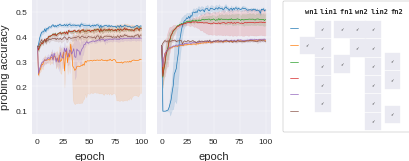

In [ ]:
sweep = api.sweep('safelix/DINO/sweeps/1yk9hdhx').runs # L2Bottleneck with MSE and t_init_eps=1e-10
cfgs = ['-/lb/fn/wn/l/-', 'wn/lb/-/wn/l/-', '-/lb/fn/-/l/fn', '-/lb/-/-/l/fn', '-/lb/-/-/l/-', '-/-/-/-/l/fn']
plot_bottleneck(runs, cfgs=cfgs)
plt.subplots_adjust(hspace=-1)
plt.savefig('init-distill-l2bot-mse.pdf', bbox_inches='tight')
plt.show()

#### Investigating Output Dimension

In [ ]:
from matplotlib import cm
@plt.rc_context(figsizes.icml2022_half(nrows=1, ncols=2, height_to_width_ratio=1))
def plot_outdim(runs, legend=False):
    f, ax = plt.subplots(nrows=1, ncols=2, width_ratios=[0.5, 0.5], sharey=True)

    summary = plot_agg(runs, group_by='out_dim', colors=cm.viridis_r, metric='probe/student', ax=ax[0])

    ax[1].plot(summary.index, summary['mean'], color='gray', linestyle='-')
    for idx, elem in summary.iterrows():
        #ax[1].errorbar(idx, elem['mean'], elem['std'], capsize=1.5, ecolor='k')
        ax[1].scatter(idx, elem['mean'], color=elem['color'], s=10, zorder=2)

    #ax[0].set_xlim(0, 50)
    #ax[0].set_ylim(0.3, 0.5)
    ax[0].set_ylim(0.01, 0.55)

    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('probing accuracy')

    ax[1].set_xscale('log', base=2)
    #ax[1].set_xlim(2**4.5, 2**16.5)
    #ax[1].set_ylim(0.3, 0.5)
    ax[1].set_xlabel('size')
    #ax[1].xaxis.get_major_locator().set_params(nbins=7)
    #ax[1].set_ylabel('best accuracy')
    #ax[1].set_xticks(summary.index, minor=True)

    handles, labels = ax[0].get_legend_handles_labels()
    if legend:
        ax[1].legend(handles[::-1], labels[::-1], bbox_to_anchor=(1, 0.5), loc='center left', frameon=False,  borderpad=0)

    return summary

Found 13 runs:
[<Run safelix/DINO/3ohf57xt (finished)>, <Run safelix/DINO/lfp5818z (finished)>, <Run safelix/DINO/plpjfoez (finished)>, <Run safelix/DINO/1mm4167o (finished)>, <Run safelix/DINO/2o9rg4m0 (finished)>, <Run safelix/DINO/3sxa7zkz (finished)>, <Run safelix/DINO/r02w9hdy (finished)>, <Run safelix/DINO/aq7fvdr5 (finished)>, <Run safelix/DINO/4s1fywyr (finished)>, <Run safelix/DINO/4azg0yaz (finished)>, <Run safelix/DINO/pggxvtk4 (finished)>, <Run safelix/DINO/2azx46kw (finished)>, <Run safelix/DINO/ic90x9ey (finished)>]


100%|██████████| 12/12 [00:06<00:00,  1.84it/s]


aggregated: {'32': 1, '64': 1, '128': 1, '256': 1, '512': 1, '1024': 1, '2048': 1, '4096': 1, '8192': 1, '16384': 1, '32768': 1, '65536': 1}


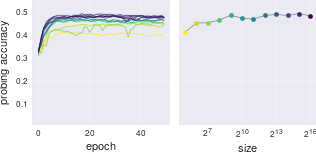

In [ ]:
# OLD SETUP: with centering & sharpening
# workaround to get runs associated with sweep https://github.com/wandb/wandb/issues/3347
sweep = api.sweep('safelix/DINO/sweeps/am04wjt4')
non_defining_config_keys = ['logdir', 'from_json', 'seed', 'out_dim']
order_by = 'config.out_dim.value'

def filter_from_config(config, exclude_keys):
    for key in exclude_keys:
        if key in config.keys():
            del config[key]

    return [{f'config.{key}':val} for (key, val) in config.items()]

filters = filter_from_config(sweep.runs[0].config, non_defining_config_keys)
runs = api.runs('safelix/DINO', filters={"$and": filters}, order=order_by)

print('Found', len(runs), 'runs:')
print(runs.objects)
runs = runs.objects[:12]

summary = plot_outdim(runs)
plt.savefig('init-distill-outdim.pdf')
plt.show()

100%|██████████| 17/17 [00:13<00:00,  1.22it/s]


aggregated: {'1': 1, '2': 1, '4': 1, '8': 1, '16': 1, '32': 1, '64': 1, '128': 1, '256': 1, '512': 1, '1024': 1, '2048': 1, '4096': 1, '8192': 1, '16384': 1, '32768': 1, '65536': 1}


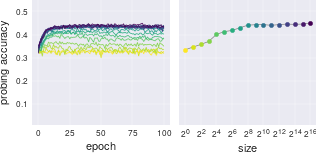

In [ ]:
runs = list(api.sweep('safelix/DINO/sweeps/ttrknul5').runs) # ResNet18: new outdim sweep with totally symmetric setup
runs += list(api.sweep('safelix/DINO/sweeps/jq4ro28q').runs)
summary = plot_outdim(runs)
#plt.gca().set_xticks(summary.index[::4], major=True)
plt.gca().set_xticks(summary.index[::2])
plt.savefig('init-distill-outdim.pdf')
plt.show()

100%|██████████| 17/17 [00:15<00:00,  1.13it/s]


aggregated: {'1': 1, '2': 1, '4': 1, '8': 1, '16': 1, '32': 1, '64': 1, '128': 1, '256': 1, '512': 1, '1024': 1, '2048': 1, '4096': 1, '8192': 1, '16384': 1, '32768': 1, '65536': 1}


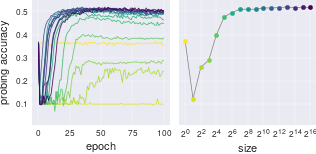

In [ ]:
runs = api.sweep('safelix/DINO/sweeps/fiqzn6mi').runs # VGG11: outdim sweep with totally symmetric setup
summary = plot_outdim(runs)
#plt.gca().set_xticks(summary.index[::4], major=True)
plt.gca().set_xticks(summary.index[::2])
plt.savefig('init-distill-outdim-vgg11.pdf')
plt.show()

100%|██████████| 17/17 [00:13<00:00,  1.23it/s]


aggregated: {'1': 1, '2': 1, '4': 1, '8': 1, '16': 1, '32': 1, '64': 1, '128': 1, '256': 1, '512': 1, '1024': 1, '2048': 1, '4096': 1, '8192': 1, '16384': 1, '32768': 1, '65536': 1}


100%|██████████| 17/17 [00:10<00:00,  1.56it/s]


aggregated: {'1': 1, '2': 1, '4': 1, '8': 1, '16': 1, '32': 1, '64': 1, '128': 1, '256': 1, '512': 1, '1024': 1, '2048': 1, '4096': 1, '8192': 1, '16384': 1, '32768': 1, '65536': 1}


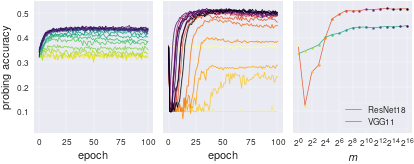

In [ ]:
from matplotlib import cm
import numpy as np

with plt.rc_context(figsizes.icml2022_half(nrows=1, ncols=1)):

    #f, ax = plt.subplots(nrows=1, ncols=3, width_ratios=[.35, .35, .3], figsize=(4.2, 1.7), sharex=False, sharey=True)
    f, ax = plt.subplots(nrows=1, ncols=3, width_ratios=[1/3, 1/3, 1/3], figsize=(4.2, 1.7), sharex=False, sharey=True)


    def plot_summary(label, summary, color, ax, size=2):


        line = ax.plot(summary.index, summary['mean'], label=label, color=color)
        ax.fill_between(summary.index, summary['mean'] - summary['std'],
                           summary['mean'] + summary['std'], color=color, alpha=0.15)
        #ax.hlines(baseline, 0, 1, color=color, linestyles='--')

        #line = ax.plot(summary.index, summary['mean'], color='gray', linestyle='-')
        for idx, elem in summary.iterrows():
            #ax.errorbar(idx, elem['mean'], elem['std'], capsize=size, ecolor='k')
            ax.scatter(idx, elem['mean'], color=elem['color'], s=size, zorder=2)



    runs = list(api.sweep('safelix/DINO/sweeps/ttrknul5').runs) # ResNet18: new outdim sweep with totally symmetric setup
    runs += list(api.sweep('safelix/DINO/sweeps/jq4ro28q').runs)
    summary_resnet = plot_agg(runs, group_by='out_dim', colors=cm.viridis_r, metric='probe/student', ax=ax[0])


    runs = api.sweep('safelix/DINO/sweeps/fiqzn6mi').runs # VGG11: outdim sweep with totally symmetric setup
    summary_vgg = plot_agg(runs, group_by='out_dim', colors=cm.inferno_r, metric='probe/student', ax=ax[1])


    plot_summary('ResNet18', summary_resnet, cm.viridis.colors[160], ax[2])
    plot_summary('VGG11', summary_vgg, cm.inferno.colors[160], ax[2])


    ax[0].set_ylabel('probing accuracy')
    ax[0].set_ylim(0.01, 0.55)

    ax[0].set_xlabel('epoch')
    ax[0].set_xticks([0, 25, 50, 75, 100])
    ax[1].set_xlabel('epoch')
    ax[1].set_xticks([0, 25, 50, 75, 100])

    ax[2].set_xlabel('$m$')
    ax[2].set_xscale('log', base=2)
    ax[2].set_xticks(summary_resnet.index[::2])
    #
    # ax[2].hlines(0, 0, 0, colors='gray', linestyles='--', label='teachers')
    ax[2].legend(frameon=True)

    plt.savefig('init-distill-outdim_v2.pdf')
    plt.show()

### Random Teacher Distillation

#### Baselines: ResNet18 vs VGG11

100%|██████████| 1/1 [00:01<00:00,  1.53s/it]


aggregated: {'teacher': 3}


100%|██████████| 1/1 [00:01<00:00,  1.29s/it]


aggregated: {'student': 3}


100%|██████████| 1/1 [00:01<00:00,  1.52s/it]


aggregated: {'teacher': 3}


100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


aggregated: {'student': 3}


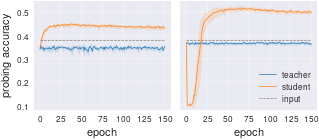

In [ ]:
def plot_init_distill(runs, title, ax=None):
    if ax is None:
        f, ax = plt.subplots(1,1)

    summary_t = plot_agg(runs, metric='probe/teacher', group_by='enc', labels='teacher', filter={'s_init_alpha':0}, colors='C0', ax=ax)
    summary_s = plot_agg(runs, metric='probe/student', group_by='enc', labels='student', filter={'s_init_alpha':0}, colors='C1', ax=ax)

    ax.hlines(baseline, 0, 150, colors='gray', linestyles='--', label='input')

    #ax.set_title(title)
    ax.set_ylim(0.08, 0.55)
    ax.set_xlabel('epoch')
    ax.set_ylabel('probing accuracy')
    ax.yaxis.get_major_locator().set_params(nbins=7)
    ax.xaxis.get_major_locator().set_params(nbins=7)
    #ax.set_xticks([5 + 10*i for i in range(5)], minor=True)
    #ax.set_yticks([0.1 + 0.2*i for i in range(5)], minor=True)
    #ax.grid(visible=True, which='minor', linewidth=0.5)
    return summary_t


with plt.rc_context(figsizes.icml2022_half(nrows=1, ncols=2, height_to_width_ratio=0.9)): #figsizes._GOLDEN_RATIO
    f, ax = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)

    runs = api.sweep('safelix/DINO/sweeps/6wi55x8r').runs # ResNet18 (Initinterp var_preserving)
    runs = api.sweep('safelix/DINO/sweeps/lurecxja').runs # ResNet18 (Initinterp var_preserving) new
    summary = plot_init_distill(runs, 'ResNet18', ax=ax[0])
    baseline_resnet = summary['mean']

    runs = api.sweep('safelix/DINO/sweeps/n255jkzk').runs # VGG11 (Inititerp)
    runs = api.sweep('safelix/DINO/sweeps/241oiehg').runs # VGG11 (Initinterp var_preserving)
    runs = api.sweep('safelix/DINO/sweeps/z654topq').runs # VGG11 (Initinterp var_preserving) new
    summary = plot_init_distill(runs, 'VGG11', ax=ax[1])
    baseline_vgg = summary['mean']

    ax[1].set_ylabel('')
    ax[1].legend(frameon=True)

    plt.savefig('init_distill.small.pdf')
    #plt.savefig('init_distill.full.pdf')
    plt.show()

#### Dataset Sizes

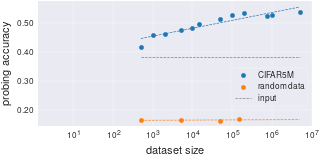

In [ ]:
@plt.rc_context(figsizes.icml2022_half(nrows=1, ncols=1))#, height_to_width_ratio=1)):
def scatter_datasetsize(sizes, values, label='', xlim=None, ax=None):
    if ax is None:
        f, ax = plt.subplots(1, 1, sharex=True, sharey=True)

    ax.scatter(sizes, values, label=label, s=10)
    a , b = np.polyfit(np.log(sizes), values, 1)

    if xlim is not None:
        sizes = list(sorted(sizes + list(xlim)))
    ax.plot(sizes, [a * np.log(x) + b for x in sizes], '--') #, label='fit: $\\alpha * \\log(x) + \\beta$')
    ax.set_xscale('log')

# From wandb.com/sanagos/DINO_new
dataset_size = [500, 1000, 2000, 5000, 10000, 15000, 50000, 100000, 200000, 750000, 1000000, 5000000]
values_true = [41.76, 45.94, 46.18, 47.66, 48.43, 49.51, 51.36, 52.75, 53.51, 52.56, 52.65, 53.67]
values_true = np.array(values_true) * 0.01

dataset_size_random = [500, 5000, 50000, 150000]
values_random = [16.47, 16.35, 16.27, 16.73]
values_random = np.array(values_random) * 0.01


#with plt.rc_context(figsizes.icml2022_half(nrows=1, ncols=1)):#, height_to_width_ratio=1)):
with plt.rc_context(figsizes.icml2022_half(nrows=1, ncols=3, height_to_width_ratio=1.5)): # to match size
    xlim= (dataset_size[0], dataset_size[-1])
    f, ax = plt.subplots(1, 1, sharex=True, sharey=True)
    scatter_datasetsize(dataset_size, values_true, label='CIFAR5M', ax=ax)
    scatter_datasetsize(dataset_size_random, values_random, label='random data', xlim=xlim, ax=ax)
    ax.hlines(baseline, *xlim, colors='gray', linestyles='--', label='input')

    ax.legend(frameon=True, fancybox=False, bbox_to_anchor=(0.5, 0., 0.5, 0.5)) # bottom right quadrant

    ax.set_yticks([0.2, 0.3, 0.4, 0.5])
    ax.set_yticklabels(['0.20', '0.30', '0.40', '0.50'])
    ax.set_ylabel('probing accuracy')
    ax.set_xlabel('dataset size')

    plt.savefig('dataset_size_v2.pdf')
    plt.show()

### Separately Initialized Teacher & Student

#### Interpolate

100%|██████████| 11/11 [00:20<00:00,  1.91s/it]


aggregated: {'0': 3, '0.1': 3, '0.2': 3, '0.3': 3, '0.4': 3, '0.5': 2, '0.6': 3, '0.7': 4, '0.8': 3, '0.9': 3, '1': 2}


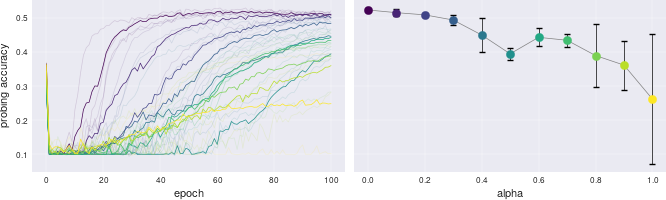

In [ ]:
from matplotlib.cm import viridis, viridis_r

nrows, ncols = 1, 2
@plt.rc_context(figsizes.icml2022_full(nrows=nrows, ncols=ncols))
def plot_interpolate(runs):

    f, ax = plt.subplots(nrows, ncols, sharey=True)

    # plot aggregates
    summary = plot_agg(runs, group_by='s_init_alpha', metric='probe/student', colors=viridis, agg=None, ax=ax[0])

    # plot summary
    ax[1].plot(summary.index, summary['mean'], color='gray', linestyle='-')
    for idx, elem in summary.iterrows():
        ax[1].errorbar(idx, elem['mean'], elem['std'], capsize=2.5, ecolor='k')
        ax[1].scatter(idx, elem['mean'], color=elem['color'], zorder=2)

    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('probing accuracy')
    ax[1].set_xlabel('alpha')

    return summary

runs = api.sweep('safelix/DINO/sweeps/n255jkzk').runs # VGG11, Adam: CE
plot_interpolate(runs)
plt.savefig('interpolate-vgg11.pdf')
plt.show()



100%|██████████| 22/22 [00:39<00:00,  1.79s/it]


aggregated: {'0': 3, '1e-10': 3, '0.05': 3, '0.1': 3, '0.15': 3, '0.2': 3, '0.25': 3, '0.3': 3, '0.35': 3, '0.4': 2, '0.45': 3, '0.5': 3, '0.55': 3, '0.6': 3, '0.65': 3, '0.7': 3, '0.75': 3, '0.8': 3, '0.85': 4, '0.9': 3, '0.95': 3, '1': 3}


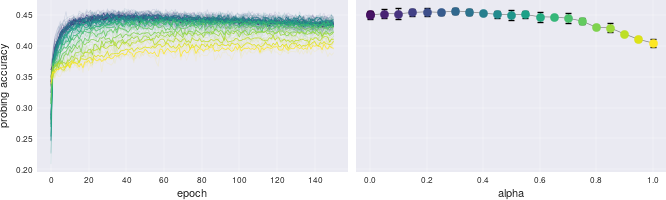

In [ ]:
runs = api.sweep('safelix/DINO/sweeps/lurecxja').runs # ResNet18, Adam: CE
summary_resnet = plot_interpolate(runs)
plt.savefig('interpolate-resnet18.pdf')
plt.show()


100%|██████████| 22/22 [00:51<00:00,  2.35s/it]


aggregated: {'0': 3, '1e-10': 3, '0.05': 3, '0.1': 3, '0.15': 3, '0.2': 3, '0.25': 3, '0.3': 3, '0.35': 3, '0.4': 3, '0.45': 3, '0.5': 3, '0.55': 3, '0.6': 4, '0.65': 2, '0.7': 3, '0.75': 3, '0.8': 3, '0.85': 3, '0.9': 3, '0.95': 3, '1': 3}


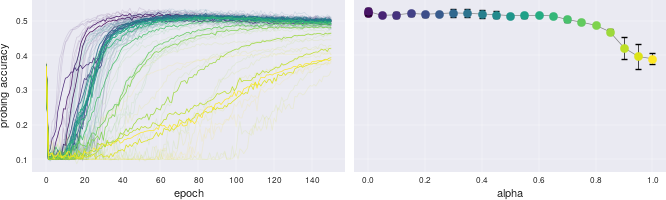

In [ ]:

runs = api.sweep('safelix/DINO/sweeps/z654topq').runs # VGG11, Adam: CE
summary_vgg = plot_interpolate(runs)
plt.savefig('interpolate-vgg11.pdf')
plt.show()

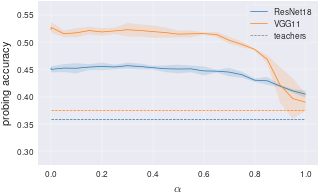

In [ ]:
with plt.rc_context(figsizes.icml2022_half(nrows=1, ncols=1)):

    f, ax = plt.subplots(1, 1, sharex=True, sharey=True)
    ax.plot(summary_resnet.index, summary_resnet['mean'], label='ResNet18')
    ax.fill_between(summary_resnet.index, summary_resnet['mean'] - summary_resnet['std'],
                        summary_resnet['mean'] + summary_resnet['std'], alpha=0.15)

    ax.fill_between(summary_vgg.index, summary_vgg['mean'] - summary_vgg['std'],
                        summary_vgg['mean'] + summary_vgg['std'], alpha=0.15)
    ax.plot(summary_vgg.index, summary_vgg['mean'], label='VGG11')


    #ax.hlines(baseline, 0, 1, colors='gray', linestyles='--', label='input')
    ax.hlines(baseline_resnet, 0, 1, color='C0', linestyles='--')
    ax.hlines(baseline_vgg, 0, 1,  color='C1', linestyles='--')
    ax.hlines(0, 0, 0, colors='gray', linestyles='--', label='teachers')

    ax.set_ylabel('probing accuracy')
    ax.set_xlabel('$\\alpha$')
    ax.set_ylim(0.275, 0.575)



    plt.legend(frameon=True)
    plt.savefig('interpolate.pdf')
    plt.show()

100%|██████████| 22/22 [00:38<00:00,  1.73s/it]


aggregated: {'0': 3, '1e-10': 3, '0.05': 3, '0.1': 3, '0.15': 3, '0.2': 3, '0.25': 3, '0.3': 3, '0.35': 3, '0.4': 2, '0.45': 3, '0.5': 3, '0.55': 3, '0.6': 3, '0.65': 3, '0.7': 3, '0.75': 3, '0.8': 3, '0.85': 4, '0.9': 3, '0.95': 3, '1': 3}


100%|██████████| 22/22 [00:29<00:00,  1.35s/it]


aggregated: {'0': 3, '1e-10': 3, '0.05': 3, '0.1': 3, '0.15': 3, '0.2': 3, '0.25': 3, '0.3': 3, '0.35': 3, '0.4': 3, '0.45': 3, '0.5': 3, '0.55': 3, '0.6': 4, '0.65': 2, '0.7': 3, '0.75': 3, '0.8': 3, '0.85': 3, '0.9': 3, '0.95': 3, '1': 3}


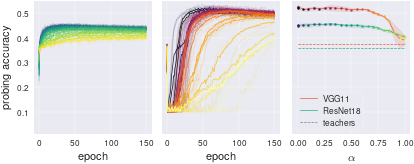

In [ ]:
from matplotlib import cm
import numpy as np

with plt.rc_context(figsizes.icml2022_half(nrows=1, ncols=1)):

    #f, ax = plt.subplots(nrows=1, ncols=3, width_ratios=[0.35, 0.35, 0.3], figsize=(4.2, 1.7), sharex=False, sharey=True)
    f, ax = plt.subplots(nrows=1, ncols=3, width_ratios=[1/3, 1/3, 1/3], figsize=(4.2, 1.7), sharex=False, sharey=True)


    def plot_summary(label, summary, baseline, color, ax, size=2):


        line = ax.plot(summary.index, summary['mean'], label=label, color=color)
        ax.fill_between(summary.index, summary['mean'] - summary['std'],
                           summary['mean'] + summary['std'], color=color, alpha=0.15)
        ax.hlines(baseline, 0, 1, color=color, linestyles='--')

        #line = ax.plot(summary.index, summary['mean'], color='gray', linestyle='-')
        for idx, elem in summary.iterrows():
            #ax.errorbar(idx, elem['mean'], elem['std'], capsize=size, ecolor='k')
            ax.scatter(idx, elem['mean'], color=elem['color'], s=size, zorder=2)



    runs = api.sweep('safelix/DINO/sweeps/lurecxja').runs # ResNet18, Adam: CE
    summary_resnet = plot_agg(runs, group_by='s_init_alpha', metric='probe/student', colors=cm.viridis, agg=None, ax=ax[0])

    runs = api.sweep('safelix/DINO/sweeps/z654topq').runs # VGG11, Adam: CE
    summary_vgg = plot_agg(runs, group_by='s_init_alpha', metric='probe/student', colors=cm.inferno, agg=None, ax=ax[1])

    plot_summary('VGG11', summary_vgg, baseline_vgg, cm.inferno.colors[160], ax[2])
    plot_summary('ResNet18', summary_resnet, baseline_resnet, cm.viridis.colors[160], ax[2])


    ax[0].set_ylabel('probing accuracy')
    ax[0].set_ylim(0.01, 0.55)

    ax[0].set_xlabel('epoch')
    #ax[0].set_xticks([0, 25, 50, 75, 100])
    ax[1].set_xlabel('epoch')
    #ax[1].set_xticks([0, 25, 50, 75, 100])

    ax[2].set_xlabel('$\\alpha$')
    ax[2].set_xticks([0, .25, .5, .75, 1])

    ax[2].hlines(0, 0, 0, colors='gray', linestyles='--', label='teachers')
    ax[2].legend(frameon=True)

    plt.savefig('interpolate_v2.pdf')
    plt.show()

In [ ]:
from matplotlib import cm
import numpy as np

with plt.rc_context(figsizes.icml2022_half(nrows=1, ncols=3, height_to_width_ratio=1.5)):

    #f, ax = plt.subplots(nrows=1, ncols=3, width_ratios=[0.35, 0.35, 0.3], figsize=(4.2, 1.7), sharex=False, sharey=True)
    #f, ax = plt.subplots(nrows=1, ncols=3, width_ratios=[1/3, 1/3, 1/3], figsize=(4.2, 1.7), sharex=False, sharey=True)
    f, ax = plt.subplots(nrows=1, ncols=3, sharex=False, sharey=True)


    def plot_summary(label, summary, baseline, color, ax, size=2):


        line = ax.plot(summary.index, summary['mean'], label=label, color=color)
        ax.fill_between(summary.index, summary['mean'] - summary['std'],
                           summary['mean'] + summary['std'], color=color, alpha=0.15)
        ax.hlines(baseline, 0, 1, color=color, linestyles='--')

        #line = ax.plot(summary.index, summary['mean'], color='gray', linestyle='-')
        for idx, elem in summary.iterrows():
            #ax.errorbar(idx, elem['mean'], elem['std'], capsize=size, ecolor='k')
            ax.scatter(idx, elem['mean'], color=elem['color'], s=size, zorder=2)



    runs = api.sweep('safelix/DINO/sweeps/lurecxja').runs # ResNet18, Adam: CE
    summary_resnet = plot_agg(runs, group_by='s_init_alpha', metric='probe/student', colors=cm.viridis, agg='std', alpha=0.05, ax=ax[0])

    runs = api.sweep('safelix/DINO/sweeps/z654topq').runs # VGG11, Adam: CE
    summary_vgg = plot_agg(runs, group_by='s_init_alpha', metric='probe/student', colors=cm.inferno, agg='std', alpha=0.05, ax=ax[1])

    plot_summary('VGG11', summary_vgg, baseline_vgg, cm.inferno.colors[160], ax[2])
    plot_summary('ResNet18', summary_resnet, baseline_resnet, cm.viridis.colors[160], ax[2])


    ax[0].set_ylabel('probing accuracy')
    ax[0].set_ylim(0.01, 0.55)

    ax[0].set_xlabel('epoch')
    ax[0].set_xticks([0, 50, 100, 150])
    ax[1].set_xlabel('epoch')
    ax[1].set_xticks([0, 50, 100, 150])

    ax[2].set_xlabel('$\\alpha$')
    ax[2].set_xticks([0, .25, .5, .75, 1], ['0', '', '0.5', '', '1'], minor=False)

    ax[2].hlines(0, 0, 0, colors='gray', linestyles='--', label='teachers')
    ax[2].legend(frameon=True)

    plt.savefig('interpolate_v2.small.pdf')
    plt.show()

#### Interpolate Trajectories

In [ ]:
from matplotlib import cm

nrows, ncols = 3, 3
@plt.rc_context(figsizes.icml2022_half(nrows=nrows, ncols=ncols, height_to_width_ratio=1.5))
def plot_interpolate_traj(runs_resnet, runs_vgg):

    f, ax = plt.subplots(nrows, ncols, sharex='col', sharey='row')

    def plot_summary(label, summary, color, ax, size=2):
        line = ax.plot(summary.index, summary['mean'], label=label, color=color)
        ax.fill_between(summary.index, summary['mean'] - summary['std'],
                           summary['mean'] + summary['std'], color=color, alpha=0.15)
        #ax.hlines(baseline, 0, 1, color=color, linestyles='--')

        #line = ax.plot(summary.index, summary['mean'], color='gray', linestyle='-')
        for idx, elem in summary.iterrows():
            #ax.errorbar(idx, elem['mean'], elem['std'], capsize=size, ecolor='k')
            ax.scatter(idx, elem['mean'], color=elem['color'], s=size, zorder=2)


    # plot aggregates resnet
    kwargs = dict(xmetric='epoch', colors=cm.viridis, reverse_sort=True, agg='std', alpha=0.05)
    kwargs_scan = dict(ema_alpha=1, scan_step=30, summary_type='last')

    summary_loss = plot_agg(runs_resnet, group_by='s_init_alpha', metric='train/KL', ax=ax[0][0], **{**kwargs_scan, **kwargs})
    plot_summary('ResNet18', summary_loss, cm.viridis.colors[160], ax[0][-1])

    summary_dist = plot_agg(runs_resnet, group_by='s_init_alpha', metric='params/norm(stud - init)', ax=ax[1][0], **{**kwargs_scan, **kwargs})
    plot_summary('ResNet18', summary_dist, cm.viridis.colors[160], ax[1][-1])

    summary_probe = plot_agg(runs_resnet, group_by='s_init_alpha', metric='probe/student', ax=ax[2][0], **kwargs)
    plot_summary('ResNet18', summary_probe, cm.viridis.colors[160], ax[2][-1])


    # plot aggregates vgg
    kwargs = dict(xmetric='epoch', colors=cm.inferno, reverse_sort=True, agg='std', alpha=0.05)
    kwargs_scan = dict(ema_alpha=1, scan_step=30, summary_type='last')

    summary_loss = plot_agg(runs_vgg, group_by='s_init_alpha', metric='train/KL', ax=ax[0][1], **{**kwargs_scan, **kwargs})
    plot_summary('VGG11', summary_loss, cm.inferno.colors[160], ax[0][-1])

    summary_dist = plot_agg(runs_vgg, group_by='s_init_alpha', metric='params/norm(stud - init)', ax=ax[1][1], **{**kwargs_scan, **kwargs})
    plot_summary('VGG11', summary_dist, cm.inferno.colors[160], ax[1][-1])

    summary_probe = plot_agg(runs_vgg, group_by='s_init_alpha', metric='probe/student', ax=ax[2][1], **kwargs)
    plot_summary('VGG11', summary_probe, cm.inferno.colors[160], ax[2][-1])


    ax[0][-1].legend()
    ax[0][0].set_ylabel('kl divergence')
    ax[1][0].set_ylabel('distance from init')
    ax[2][0].set_ylabel('probing accuracy')

    #ax[0].set_yscale('log')
    ax[0][0].set_ylim([0, 2e-5])

    ax[2][0].set_xlabel('epoch')
    ax[2][0].set_xticks([0, 50, 100, 150])
    ax[2][1].set_xlabel('epoch')
    ax[2][1].set_xticks([0, 50, 100, 150])

    ax[2][-1].set_xlabel('$\\alpha$')
    ax[2][-1].set_xticks([0, .25, .5, .75, 1], ['0', '', '0.5', '', '1'], minor=False)


with plt.rc_context(figsizes.icml2022_half(nrows=nrows, ncols=ncols, height_to_width_ratio=1)):
    runs_resnet = api.sweep('safelix/DINO/sweeps/lurecxja').runs # ResNet18, Adam: CE
    runs_vgg11 = api.sweep('safelix/DINO/sweeps/z654topq').runs # VGG11, 150 epochs

    #runs_resnet = [runs_resnet[0], runs_resnet[len(runs)//2], runs_resnet[-1]]
    #runs_vgg11 = [runs_vgg11[0], runs_vgg11[len(runs)//2], runs_vgg11[-1]]
    plot_interpolate_traj(runs_resnet, runs_vgg11)
    plt.savefig('interpolate-traj.pdf')
    plt.show()

#### Restarting

In [ ]:
from matplotlib.cm import viridis, viridis_r

nrows, ncols = 3, 1
@plt.rc_context(figsizes.icml2022_half(nrows=nrows, ncols=ncols))
def plot_traj(runs, colors=None, ax=None):
    if ax is None:
        f, ax = plt.subplots(nrows, ncols, sharex=True)

    # plot aggregates
    kwargs = dict(xmetric='epoch', labels=['ResNet18', 'VGG11'], colors=colors, agg=None, alpha=0.) # ,xmetric='epoch'
    summary_loss = plot_agg(runs, group_by='enc', metric='train/KL', scan_step=1, ema_alpha=0.1, ax=ax[0], **kwargs)
    summary_dist = plot_agg(runs, group_by='enc', metric='params/norm(stud - init)', scan_step=1, ema_alpha=0.1, ax=ax[1], **kwargs)
    summary_probe = plot_agg(runs, group_by='enc', metric='probe/student', ax=ax[2], **kwargs)


    # plot summary
    #ax[1].plot(summary.index, summary['mean'], color='gray', linestyle='-')
    #for idx, elem in summary.iterrows():
    #    ax[1].errorbar(idx, elem['mean'], elem['std'], capsize=2.5, ecolor='k')
    #    ax[1].scatter(idx, elem['mean'], color=elem['color'], zorder=2)

    ax[0].set_ylabel('kl divergence')
    ax[0].set_ylim([-0.2e-5, 5e-5])
    #ax[0].set_yscale('log')

    ax[1].set_ylabel('distance from init')

    ax[2].set_ylabel('probing accuracy')
    ax[2].set_xlabel('epoch')



nrows, ncols = 3, 2
@plt.rc_context(figsizes.icml2022_half(nrows=nrows, ncols=ncols, height_to_width_ratio=1))
def plot_restart_traj(runs_left, runs_right, colors=None):
    f, ax = plt.subplots(nrows, ncols, sharex='col', sharey='row')
    plot_traj(runs_left, colors=colors, ax=[ax[0][0], ax[1][0], ax[2][0]])
    #ax[0][0].set_title('First Round of Distillation')

    plot_traj(runs_right, colors=colors, ax=[ax[0][1], ax[1][1], ax[2][1]])
    #ax[0][1].set_title('Second Round of Distillation')

    ax[0][1].set_xlim([-1, 20])
    ax[0][1].set_xticks([0, 5, 10, 15, 20])

    ax[0][1].legend()

with plt.rc_context(figsizes.icml2022_half(nrows=nrows, ncols=ncols, height_to_width_ratio=1)):
    runs_left = [api.run('safelix/DINO/runs/22abl14o'),  api.run('safelix/DINO/runs/2b1fre3w')]   # original
    runs_right = [api.run('safelix/DINO/runs/16dagoay'), api.run('safelix/DINO/runs/2h1600vx')]  # restart
    plot_restart_traj(runs_left, runs_right, colors=[cm.viridis.colors[160], cm.inferno.colors[160]])
    plt.savefig('restart.pdf')
    plt.show()

#### Losslandscapes

In [ ]:
import json
from glob import glob
from losslandscape import ParamProjector
from configuration import load_model
from matplotlib.image import AxesImage
from matplotlib.colors import LogNorm, Normalize
device = torch.device(U.pick_single_gpu())

def plot_landscape(runname, metric, labels=[0,1,2], ax=None, device=torch.device('cpu'), pointer=None) -> AxesImage:
    if ax is None:
        ax = plt.figure().gca()

    cmap = 'viridis' if 'probe' in metric else 'viridis_r'
    #cmap = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True, reverse=True)
    #cmap = sns.color_palette(cmap, as_cmap=True)

    # Load vectors
    path = os.path.join(os.environ['DINO_RESULTS'], 'losslandscape', runname)
    with open(os.path.join(path, 'args.json')) as f:
        args = json.load(f)

    fnames = [args['vec0'], args['vec1'], args['vec2']]
    fnames = [os.path.join(os.environ['DINO_RESULTS'], fname) for fname in fnames]

    vecs = [U.module_to_vector(load_model(fname)).to(device) for fname in fnames]

    # Prepare Plane
    X = torch.arange(args['xmin'], args['xmax'] + args['stepsize'], args['stepsize'])
    Y = torch.arange(args['ymin'], args['ymax'] + args['stepsize'], args['stepsize'])

    # Plot metric in plane
    Z:torch.Tensor = torch.load(os.path.join(path, f'{metric}.pt'))

    print(os.path.join(path, f'{metric}.pt'))
    print(f'Z.min() = {Z.nan_to_num(float("inf")).min():.3e}, Z.max() = {Z.nan_to_num(float("-inf")).max():.3e}, Z.shape = {Z.shape}')

    extent = (X.min() - args['stepsize']/2, X.max() + args['stepsize']/2,
                Y.min() - args['stepsize']/2, Y.max() + args['stepsize']/2)
    img = ax.imshow(Z.T, cmap=cmap, interpolation='none', origin='lower', extent=extent)
    #img = ax.pcolormesh(X, Y, Z.T)

    # Plot contours of l2norms
    l2norms = torch.load(os.path.join(path, 'l2norm.pt'))
    contours = ax.contour(X, Y, l2norms.T, alpha=0.2, colors='w')
    ax.clabel(contours, fontsize=plt.rcParams['xtick.labelsize'])

    # Plot and anotate vecs in plane
    P = ParamProjector(vecs[0], vecs[1], vecs[2], args['projector_center'], args['projector_scale'])
    for idx, (vec, label) in enumerate(zip(vecs, labels)):
        coord = P(vec).cpu()
        scat = ax.scatter(*coord, label=label, marker='o', edgecolors='firebrick', facecolors=(1,1,1,0)) # s=50,
        if label is not None:
            if idx == 0:
                offset = (-1, +5)
            if idx == 1:
                offset = (-11,+5)
            if idx == 2:
                offset = (-1, +5)
            ax.annotate(label, coord, offset, textcoords='offset pixels', fontweight='bold',
                        c='firebrick', fontsize=plt.rcParams['axes.labelsize']) # crimson #fontsize=14,

    ax.axis('scaled')
    ax.set_xlim((args['xmin'], args['xmax']))
    ax.set_ylim((args['ymin'], args['ymax']))
    ax.grid(visible=True, alpha=0.0)

    if pointer is not None:
        if 'width' not in pointer.keys():
            pointer['width'] = 0.001 # set default

        coord1, coord2 = P(vecs[pointer['start']]).cpu(), P(vecs[pointer['end']]).cpu()
        direction = (coord2 - coord1) / (coord2 - coord1).norm()
        coord2 = coord1 + pointer['scale'] * direction
        start = coord1 + pointer['margin'] * direction
        end = coord2 - pointer['margin'] * direction
        ax.arrow(*start, *(end-start), color='firebrick', width=pointer['width'])
        ax.annotate(labels[pointer['end']], coord2, fontweight='bold',
                    c='firebrick', fontsize=plt.rcParams['axes.labelsize']) # crimson #fontsize=14,)
    return img

In [ ]:
from mpl_toolkits.axes_grid1 import ImageGrid
@plt.rc_context({'figure.constrained_layout.use':False})
def plot_row(runs, metric, grid, vlim=(None, None), lognorm=False):
    imgs = []
    for (run, run_kwargs), ax in zip(runs.items(), grid):
        im = plot_landscape(run, metric, ax=ax, device=device, **run_kwargs)
        imgs.append(im)

    # compute vmin, vmax over all images
    vmin = min(im.norm.vmin for im in imgs) if vlim[0] is None else vlim[0]
    vmax = min(im.norm.vmax for im in imgs) if vlim[1] is None else vlim[1]

    # set norm for all images
    norm = LogNorm(vmin, vmax) if lognorm else Normalize(vmin, vmax)
    for im in imgs:
        im.norm = norm

    # adding to one will add to all, they are shared
    plt.colorbar(imgs[0], cax=grid[0].cax)
    return

@plt.rc_context({'figure.constrained_layout.use':False})
def plot_grid(runs, metrics, figsize=None):
    fig = plt.figure(figsize=figsize)
    grid = ImageGrid(fig, 111,  # similar to subplot(143)
                        nrows_ncols=(len(metrics), len(runs)),
                        axes_pad=0.1,
                        #label_mode='all',
                        label_mode='L',
                        share_all=True,
                        cbar_location="right",
                        cbar_mode="edge",
                        cbar_size="7%",
                        cbar_pad="2%",
                        )
    idx = 0
    for metric, metric_kwargs in metrics.items():
        plot_row(runs, metric, grid[idx:idx+len(runs)], **metric_kwargs)
        idx += len(runs)
    return grid

#### Interpolate Plane

In [ ]:
with plt.rc_context(figsizes.icml2022_half(nrows=2, ncols=2, height_to_width_ratio=1)):
    runs = {'2023-01-12--18-58-26': dict(labels=[   r'$\boldsymbol{ \theta_T        }$',
                                                    r'$\boldsymbol{ \theta_S(1)        }$',
                                                    r'$\boldsymbol{ \theta_S^*(1)   }$']),
            '2023-01-12--18-58-27': dict(labels=[   r'$\boldsymbol{ \theta_T        }$',
                                                    r'$\boldsymbol{ \theta_S^*(0)   }$',
                                                    r'$\boldsymbol{ \theta_S^*(1)   }$'])}

    metrics = {'train_KL': dict(vlim=(1e-7, 1e-3), lognorm=True),
                'probe_lin': dict(vlim=(0.1, 0.5), lognorm=False)}

    grid = plot_grid(runs, metrics)
    grid[0].set_ylabel('loss landscape')
    grid[2].set_ylabel('probing landscape')
    grid[0].set_title('non-local view')
    grid[1].set_title('shared view')
    plt.savefig('losslandscape.pdf')
    plt.show()

In [ ]:

with plt.rc_context(figsizes.icml2022_half(nrows=1, ncols=1, height_to_width_ratio=1)):
    metrics = {'train_KL': dict(vlim=(1e-7, 1e-3), lognorm=True)}
    runs = {'2023-01-12--14-47-42-cropped': #'2023-01-12--14-47-42':
            dict(labels=[r'$\boldsymbol{ \theta_T       }$',
                         r'$\boldsymbol{ \theta_S^*(0)   }$',
                         r'$\boldsymbol{ \theta_S^*(1) }$'],
                pointer={'start':0, 'end':1, 'scale':0.145, 'margin':0.01, 'width':0.001})}

    #img = plot_landscape(run, metric, labels=metric, ax=ax, device=device)
    plot_grid(runs, metrics)
    plt.savefig('losslandscape_zoom.pdf')
    plt.show()

#### Orthogonal Projection

In [ ]:
with plt.rc_context(figsizes.icml2022_full(nrows=2, ncols=2, height_to_width_ratio=0.8)):
    runs = {'2023-01-12--18-57-40': dict(labels=[   r'$\boldsymbol{ \theta_T        }$',
                                                    r'$\boldsymbol{ \theta_S(1)     }$',
                                                    r'$\boldsymbol{ \theta_S^*(1)   }$']),
            '2023-01-12--18-57-41': dict(labels=[   r'$\boldsymbol{ \theta_T        }$',
                                                    r'$\boldsymbol{ \theta_S^*(0)   }$',
                                                    r'$\boldsymbol{ \theta_S^*(1)   }$'])}

    metrics = {'train_KL': dict(vlim=(1e-7, 1e-3), lognorm=True),
                'probe_lin': dict(vlim=(0.1, 0.5), lognorm=False)}

    grid = plot_grid(runs, metrics)
    grid[0].set_ylabel('loss landscape')
    grid[2].set_ylabel('probing landscape')
    grid[0].set_title('non-local view')
    grid[1].set_title('shared view')
    plt.savefig('losslandscape_ortho.pdf')
    plt.show()

In [ ]:
figsizes.icml2022_half(nrows=1, ncols=1, height_to_width_ratio=1)

In [ ]:
params = figsizes.icml2022_half(nrows=1, ncols=1, height_to_width_ratio=1)
params['figure.figsize'] = tuple([v/3 for v in params['figure.figsize']])
with plt.rc_context(figsizes.icml2022_half(nrows=1, ncols=1, height_to_width_ratio=1)):
    metrics = {'train_KL': dict(vlim=(1e-7, 1e-3), lognorm=True)}
    runs = {'2023-01-13--10-46-11':
            dict(labels=[r'$\boldsymbol{ \theta_T       }$',
                        r'$\boldsymbol{ \theta_S^*(0)   }$',
                        r'$\boldsymbol{ \theta_S^*(1) }$'],
                pointer={'start':0, 'end':1, 'scale':10, 'margin':1, 'width':0.1})
            }

    #img = plot_landscape(run, metric, labels=metric, ax=ax, device=device)
    plot_grid(runs, metrics)
    plt.savefig('losslandscape_ortho_zoom.pdf')
    plt.show()

#### Encoder Losslandscape

In [ ]:
with plt.rc_context(figsizes.icml2022_full(nrows=2, ncols=2, height_to_width_ratio=0.5)):
    runs = {'2023-01-17--19-59-14': dict(labels=[   r'$\boldsymbol{ \theta_T       }$',
                                                    r'$\boldsymbol{ \theta_S(1)   }$',
                                                    r'$\boldsymbol{ \theta_S^*(1) }$']),
            '2023-01-17--19-59-15': dict(labels=[   r'$\boldsymbol{ \theta_T       }$',
                                                    r'$\boldsymbol{ \theta_S^*(0) }$',
                                                    r'$\boldsymbol{ \theta_S^*(1) }$'])}

    metrics = {'train_KL': dict(vlim=(1e-6, 1), lognorm=True),
                'probe_lin': dict(vlim=(0.1, 0.5), lognorm=False)}

    grid = plot_grid(runs, metrics)
    grid[0].set_ylabel('loss landscape')
    grid[2].set_ylabel('probing landscape')
    grid[0].set_title('non-local view')
    grid[1].set_title('shared view')
    plt.savefig('losslandscape_enc_ortho.pdf')
    plt.show()

In [ ]:
with plt.rc_context(figsizes.icml2022_half(nrows=1, ncols=1, height_to_width_ratio=0.5)):
    metrics = {'train_KL': dict(vlim=(1e-6, 1), lognorm=True)}
    runs = {'2023-01-17--19-59-13':
            dict(labels=[r'$\boldsymbol{ \theta_T       }$',
                        r'$\boldsymbol{ \theta_S^*(0)   }$',
                        r'$\boldsymbol{ \theta_S^*(1) }$'],
                pointer={'start':0, 'end':1, 'scale':5, 'margin':0.7, 'width':0.05})}

    #img = plot_landscape(run, metric, labels=metric, ax=ax, device=device)
    plot_grid(runs, metrics)

    plt.savefig('losslandscape_enc_ortho_zoom.pdf')
    plt.show()

### Connection to Supervised Optimization

#### Permutation Invariance

In [ ]:
def shuffle_experiment(fname, device=torch.device('cpu')):
    import copy
    from configuration import load_model
    from torch import nn
    from torchvision import transforms
    from torch.utils.data import DataLoader
    from datasets import CIFAR10
    from dinopl import probing

    model = load_model(fname).to(device)

    s_enc, t_enc = model.student.enc, model.teacher.enc
    s_perm, t_perm = copy.deepcopy(s_enc), copy.deepcopy(s_enc)
    for p_s_enc, p_t_enc, p_s_perm, p_t_perm in zip(s_enc.parameters(), t_enc.parameters(), s_perm.parameters(), t_perm.parameters()):
        assert(p_s_enc.nelement()==p_t_enc.nelement())
        idx = torch.randperm(p_s_enc.nelement())
        p_s_perm.data = p_s_enc.view(-1)[idx].view(p_s_enc.size())
        p_t_perm.data = p_t_enc.view(-1)[idx].view(p_t_enc.size())

    # prepare data
    trfm = transforms.Compose([transforms.Lambda(lambda img: img.convert('RGB')), transforms.ToTensor(),
                                transforms.Normalize(CIFAR10.mean, CIFAR10.std)])
    train_set = CIFAR10(train=True, transform=trfm)
    valid_set = CIFAR10(train=False, transform=trfm)
    train_dl = DataLoader(train_set, 256, shuffle=True, num_workers=4, pin_memory=True)
    valid_dl = DataLoader(valid_set, 256, shuffle=True, num_workers=4, pin_memory=True)

    encoders = {'s_enc':s_enc, 't_enc':t_enc, 's_perm':s_perm, 't_perm':t_perm}
    probes = {'':probing.LinearAnalysis(10)}
    prober = probing.Prober(encoders, probes, train_dl, valid_dl, 10, normalize=False, seed=1234567890)
    results = prober.probe(device)
    return results

shuffle_experiment(os.path.join(os.environ['DINO_RESULTS'], 'DINO', '22abl14o', 'epoch=58-step=11564-probe_student=0.524.ckpt'), torch.device('cuda:1'))


#### Iterative Magnitude Pruning

In [ ]:
from matplotlib.ticker import MaxNLocator
from matplotlib.cm import viridis, winter, RdPu_r, summer, autumn


alpha = 0.5
basecolors = [(*winter(i)[:3], alpha) for i in np.linspace(0, 0.9, 4)]
dinocolors = 'red' #['C1', 'C2'] #[viridis.colors[i] for i in [170, 250]]


@plt.rc_context(figsizes.icml2022_half(nrows=1, ncols=1))
def plot_imp(dinoruns, baseruns, lr, s_init_alpha, xlim=None, ylim=None):
    filter = {'opt_lr':  f'MultiStep({lr}, 0.1, 80, 120)',
                'dino_config.s_init_alpha': s_init_alpha}

    f, ax = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True)
    ax = (ax, ax)

    if dinoruns is not None:
        summary0 = plot_agg(dinoruns, metric='IMP/best_acc', group_by='dino_config.s_init_alpha', filter=filter,
                lw=0.75, colors=dinocolors, alpha=0.2, zorder=2, agg='std', ax=ax[0])


    #ax[1].set_title('IMP from rewinding points')
    if baseruns is not None:
        summary1 = plot_agg(baseruns, metric='IMP/best_acc', group_by='rewind_to', filter=filter,
                    colors=basecolors, alpha=0.1, zorder=1, agg='std', ax=ax[1])

    # make x-axis
    if xlim is not None:
        ax[0].set_xlim(xlim)
    ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))
    labels = max([run.history(keys=['IMP/ratio']) for run in dinoruns], key=len)['IMP/ratio']
    ticks = [t for t in ax[0].get_xticks() if 0<=t and t<len(labels)]
    labels = [f'{100 - 100*l:.1f}%' for l in labels[ticks]] # select and format ticks
    ax[0].set_xticks(ticks) # overwrite ticks to only include between 0 and len(labels)
    ax[0].set_xticklabels(labels) # overwrite tick labels
    ax[0].set_xlabel('weights remaining (\%)')
    ax[1].set_xlabel('weights remaining (\%)')

    # make y-axis
    ax[0].set_ylabel('test accuracy')
    if ylim is not None:
        ax[0].set_ylim(ylim)

    if dinoruns is None:
        handles0, labels0 = [], []
    else:
        handles0, labels0 = ax[0].get_legend_handles_labels()
        labels0 = ['init $\\theta_{S}^*$, rewind to $\\ell=0$' for l in summary0.index] #['10^{-10}', '1']] # student $\\alpha$={l}
        #labels0 = ['student $\\alpha$=' + f'{l}' for l in summary0.index] #['10^{-10}', '1']] # student $\\alpha$={l}

    if baseruns is None:
        handles1, labels1 = [], []
    else:
        handles1, labels1 = ax[1].get_legend_handles_labels()
        labels1 = ['init $\\theta_{S}$, rewind to $\\ell=' + f'{l}$' for l in summary1.index]
        #labels1 = ['rewind to epoch=' + f'{l}' for l in summary1.index]
        ax[0].legend(handles0+handles1, labels0+labels1, frameon=True)

    #ax[0].legend(title='alpha', title_fontsize=plt.rcParams['legend.fontsize'], alignment='right')
    #ax[1].legend(title='epoch', title_fontsize=plt.rcParams['legend.fontsize'], alignment='left')


with plt.rc_context(figsizes.icml2022_half(nrows=1, ncols=1)):
    # ResNet20
    dinoruns = api.sweep('safelix/DINOfinetune/sweeps/n5ppf28e').runs # DINO students
    #baseruns = api.sweep('safelix/DINOfinetune/sweeps/mkrugq3b').runs # DINO baselines
    filters = {'$and': [{'sweep': 'mkrugq3b'}, {'config.rewind_to':{'$lte':5}}]}
    baseruns = api.runs('safelix/DINOfinetune', filters=filters)

    plot_imp(dinoruns, baseruns, lr=0.05, s_init_alpha=1e-10, xlim=(0, 15), ylim=(0.82, 0.92))
    plt.savefig('imp-resnet20_v2.pdf')
    plt.show()

In [ ]:
with plt.rc_context(figsizes.icml2022_half(nrows=1, ncols=1)):
    # ResNet18
    dinoruns = api.sweep('safelix/DINOfinetune/sweeps/52u6jbb2').runs # DINO students

    #baseruns = api.sweep('safelix/DINOfinetune/sweeps/y7dxw6lc').runs # DINO baselines
    filters = {'$and': [{'sweep': 'y7dxw6lc'}, {'config.rewind_to':{'$lte':5}}]}
    baseruns = api.runs('safelix/DINOfinetune', filters=filters)

    plot_imp(dinoruns, baseruns, lr=0.1, s_init_alpha=1e-10, xlim=None, ylim=(0.90, 0.95))
    plt.savefig('imp-resnet18_v2.pdf')
    plt.show()

In [ ]:
with plt.rc_context(figsizes.icml2022_half(nrows=1, ncols=1)):
    # ResNet18
    dinoruns = api.sweep('safelix/DINOfinetune/sweeps/52u6jbb2').runs # DINO students

    #baseruns = api.sweep('safelix/DINOfinetune/sweeps/y7dxw6lc').runs # DINO baselines
    filters = {'$and': [{'sweep': 'y7dxw6lc'}, {'config.rewind_to':{'$lte':5}}]}
    baseruns = api.runs('safelix/DINOfinetune', filters=filters)

    plot_imp(None, baseruns, lr=0.1, s_init_alpha=1e-10, xlim=None, ylim=(0.90, 0.95))
    plt.savefig('imp-resnet18_v2_base.pdf')
    plt.show()

#### SGD Mode Connectivity under Different Seeds

In [ ]:
@plt.rc_context(figsizes.icml2022_half(nrows=1, ncols=2, height_to_width_ratio=1))
#@plt.rc_context(figsizes.icml2022_half(nrows=1, ncols=1))
def plot_linearconnectivity(folder, models):

    points = np.linspace(0, 1, 50)
    #fig, axes = plt.subplots(ncols=len(models), figsize=(len(models) * 3.9, 3.9), sharex=True)
    fig, axes = plt.subplots(nrows=1, ncols=len(models), sharex=True, sharey=True)

    colors = ['blue', 'red']

    for i, model in enumerate(models):
        runs = list(filter(lambda x: model in x, os.listdir(folder)))

        all_data = []
        for run in runs[:30]:
            with open(os.path.join(folder, run), 'r') as f:
                all_data.append(eval(f.read()))

            for data in all_data:
                axes[i].plot(points, 1 - np.array(data), alpha=0.01, color=colors[i])

        axes[i].plot(points, 1 - np.array(all_data).mean(0), '--', color='black', lw=0.75)

        axes[i].set_xticks([0, 1])
        axes[i].set_ylim([0.05, 0.57])

    #axes[0].set_title('$\\theta_T$')
    #axes[1].set_title('$\\theta_{S_0^*}$')
    axes[0].set_title('finetune $\\theta_S$')
    axes[1].set_title('finetune $\\theta_S^*$')

    #axes[0].set_xticklabels(['$\\theta_{\\pi_i\\to\\pi_j}(0)$', '$\\theta_{\\pi_i\\to\\pi_j}(1)$'])
    #axes[1].set_xticklabels(['$\\theta_{\\pi_i\\to\\pi_j}(0)$', '$\\theta_{\\pi_i\\to\\pi_j}(1)$'])
    axes[0].set_xticklabels(['$\\theta_{\\pi_i}^*$', '$\\theta_{\\pi_j}^*$'])
    axes[1].set_xticklabels(['$\\theta_{\\pi_i}^*$', '$\\theta_{\\pi_j}^*$'])

    #axes[0].set_xlabel('$\\gamma$')
    #axes[1].set_xlabel('$\\gamma$')

    axes[0].set_ylabel('test error')

with plt.rc_context(figsizes.icml2022_half(nrows=1, ncols=2, height_to_width_ratio=1)):
    folder =  os.path.join(os.environ['DINO_RESULTS'], 'interpolate_sgd')
    models = ['random', 'alpha_0_best']#, 'alpha_1_last']
    plot_linearconnectivity(folder, models)

    plt.savefig('linear_connectivity_v2.pdf')
    plt.show()

## Appendix

#### Optimization Behaviour

In [ ]:
groups = {
    'resnet18':[
        '1gqyr8sa',
        '170lqug8',
        'qz5j8dva',
        '26qjvyrz',
        '3bkx4c2f',
        '15j3cwn5',
    ],
    'vgg11':[
        '1ozaihai',
        '1owvg6tb',
        '2mdna4pc',
        'eiur72q2',
        '3uim3e5y',
        '2lrm7pai',
    ]
}


# plot groups
f, ax = plt.subplots(nrows=1, ncols=2, sharey=False, figsize=(10, 3.5))
for idx, (enc_name, enc_group) in enumerate(groups.items()):

    for run_id in enc_group:
        run = api.run(f'safelix/DINO/runs/{run_id}')
        hist:pd.DataFrame = run.history(keys=['probe/student'])
        if hist.empty:
            continue

        s_acc = hist['probe/student']
        s_acc.name = run.config['enc_seed']

        # plot mean and std
        name = ''
        name += run.config['opt'] + ':'
        name += ' wd=' + str(run.config['opt_wd'])
        if run.config['opt'] == 'adamw':
            name += ', betas=(' + str(run.config['opt_beta1']) + ', ' + str(run.config['opt_beta2']) + ')'

        if run.config['wn_freeze_epochs'] > 0:
            name += ', freeze_l2bot'


        ax[idx].plot(s_acc.index, s_acc, label=name)  #{hists.shape[1]}
    ax[idx].set_xlabel('epoch')
    ax[idx].set_title(enc_name)


#ax[0].legend()
ax[1].legend(bbox_to_anchor=(1, 0.5), loc='center left', frameon=True)#,  borderpad=1.0)

ax[0].set_ylabel('probing accuracy')
ax[1].set_ylabel('probing accuracy')
#ax[1].set_ylim(0.25, 0.53)

plt.subplots_adjust(hspace=0)
#plt.subplots_adjust(wspace=0.1, hspace=0)
plt.savefig('init-distill-opt.pdf', bbox_inches='tight')


In [ ]:
from itertools import takewhile

max_epoch = 25
groups = {
    'resnet18':[
        api.run('safelix/DINO/runs/1gqyr8sa'),
        api.run('safelix/DINO/runs/170lqug8'),
        api.run('safelix/DINO/runs/qz5j8dva'),
        api.run('safelix/DINO/runs/26qjvyrz'),
        api.run('safelix/DINO/runs/3bkx4c2f'),
        api.run('safelix/DINO/runs/15j3cwn5'),
    ],
    'vgg11':[
        api.run('safelix/DINO/runs/1ozaihai'),
        api.run('safelix/DINO/runs/1owvg6tb'),
        api.run('safelix/DINO/runs/2mdna4pc'),
        api.run('safelix/DINO/runs/eiur72q2'),
        api.run('safelix/DINO/runs/3uim3e5y'),
        api.run('safelix/DINO/runs/2lrm7pai'),
    ]
}

shist_metrics = [
    'train/KL', # : 'kls',
    'params/norm(stud - init)', # : 'dists',
    'train/feat/embed/s_x.corr().rank()', #:'ranks',
]

for run1, run2 in zip(groups['resnet18'], groups['vgg11']):
    assert(run1.config['opt'] == run1.config['opt'])
    assert(run1.config['opt_beta1'] == run1.config['opt_beta1'])
    assert(run1.config['opt_beta2'] == run1.config['opt_beta2'])
    assert(run1.config['wn_freeze_epochs'] == run1.config['wn_freeze_epochs'])


# plot groups
f, ax = plt.subplots(nrows=1+len(shist_metrics), ncols=2, sharex=True, sharey='row', figsize=(10, 14))
for idx, (enc_name, enc_group) in enumerate(groups.items()):

    for run in tqdm(enc_group):
        name = ''
        name += run.config['opt'] + ':'
        name += ' wd=' + str(run.config['opt_wd'])
        if run.config['opt'] == 'adamw':
            name += ', betas=(' + str(run.config['opt_beta1']) + ', ' + str(run.config['opt_beta2']) + ')'

        if run.config['wn_freeze_epochs'] > 0:
            name += ', freeze'

        # plot probing from epoch history
        ehist = run.history(keys=['probe/student'], x_axis='epoch')
        ehist = ehist.rename(columns={'probe/student':'accs'})
        ehist = ehist.head(max_epoch + 1)
        ehist['epoch'][1:] += 1

        ax[0][idx].plot(ehist['epoch'], ehist['accs'], label=name)

        for m_idx, metric in enumerate(shist_metrics):

            # get metric
            shist = run.scan_history(keys=['epoch', metric])
            shist = pd.DataFrame(takewhile(lambda elem: elem['epoch'] < max_epoch, shist))
            shist['epoch'] = np.linspace(0, shist['epoch'].iloc[-1] + 1, len(shist['epoch']))

            # remove outliers and smooth
            shist[metric] = shist[metric].rolling(3).median()
            shist[metric] = shist[metric].ewm(alpha=0.1).mean()
            shist[metric] = shist[metric]

            # plot metric
            ax[1+m_idx][idx].plot(shist['epoch'], shist[metric], label=name)

    ax[-1][idx].set_xlabel('epoch')
    ax[0][1].set_title(enc_name)


ax[0][0].set_ylim(-0.01, 0.51)
ax[1][0].set_ylim(-1e-6, 2e-5)
ax[1][0].ticklabel_format(axis='y', style='sci')

ax[0][0].legend()
#ax[0][1].legend(bbox_to_anchor=(1, 0.5), loc='center left', frameon=True)#,  borderpad=1.0)

ax[0][0].set_ylabel('probing accuracy')
ax[1][0].set_ylabel('kl divergence')
ax[2][0].set_ylabel('distance from init')
ax[3][0].set_ylabel('embedding ranks')


plt.subplots_adjust(hspace=0.1, wspace=0.1)
plt.savefig('init-distill-opt-details.pdf', bbox_inches='tight')


#### Small ConvNets

In [ ]:
sweep = api.sweep('safelix/DINO/sweeps/muerfvuw')

# gather groups
groups = {}
for run in sweep.runs:
    width, depth = run.config['enc'].split('_')[-2:]
    width = int(width)
    depth = int(depth[:-1]) + 0.5 if depth[-1] == 'e' else int(depth)

    if width not in groups.keys():
        groups[width] = {}

    if depth not in groups[width].keys():
        groups[width][depth] = []
    groups[width][depth].append(run)

# plot groups
f, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(10, 3.5))
for idx, width in enumerate(reversed(groups.keys())):
    for depth in groups[width].keys():

        hists = []
        for run in groups[width][depth]:
            hist:pd.DataFrame = run.history(keys=['probe/student'])
            if not hist.empty:
                s_acc = hist['probe/student']
                s_acc.name = run.config['enc_seed']
                hists.append(s_acc)

        print(f'{width}, {depth}: {len(hists)} runs' )
        print(f'=> seeds : {[h.name for h in hists]}')
        if len(hists) == 0:
            continue
        hists = pd.concat(hists, axis='columns')

        # plot mean and std
        hists_mean = hists.mean(axis=1, skipna=True)
        hists_std = hists.std(axis=1, skipna=True).fillna(0.0)
        line = ax[idx].plot(hists.index, hists_mean, label=depth)
        ax[idx].fill_between(hists.index, hists_mean - hists_std, hists_mean + hists_std, alpha=0.2, color=line[0].get_color())
        ax[idx].errorbar(-3, hists_mean[0], hists_std[0], capsize=2.5, marker='.', color=line[0].get_color())
    ax[idx].set_xlabel('epoch')
    ax[idx].set_title(f'convnet width {width}')


#ax[0].legend()
ax[0].legend(title='depth')
ax[0].set_ylabel('probing accuracy')
#ax[0].set_ylim(0.08, 0.53)

plt.subplots_adjust(wspace=0.1, hspace=0)
plt.savefig('init-distill-convnets.pdf', bbox_inches='tight')


#### MLPs

In [ ]:
from matplotlib import cm
@plt.rc_context(figsizes.icml2022_half(nrows=1, ncols=1, height_to_width_ratio=1/2))
def plot_mlps(runs):

    fig, (ax, legax) = plt.subplots(nrows=1, ncols=2, width_ratios=[0.8, 0.2])

    def plot_group(probe, fmt='', colors=cm.tab10.colors, legend=False):
        ax.set_prop_cycle(None)
        groups = {}
        for run in runs:
            _, width, depth = run.config['enc'].split('_')
            acc = run.summary[f'probe/{probe}']['max']

            if depth not in groups.keys():
                groups[depth] = {}
            groups[depth][width] = acc

        for idx, (depth, group) in enumerate(groups.items()):
            widths, accs = list(group.keys())[::-1], list(group.values())[::-1]
            ax.plot(widths, accs, fmt, markersize=3, c=colors[idx], label=f'depth {depth}' if legend else None)


    plot_group('student', fmt='-o', legend=True)
    plot_group('teacher', fmt='--x')

    ax.set_ylim(ax.get_ylim())
    ax.plot([0,0], [0,0], '--x', markersize=3, c='gray', label='teachers')
    ax.plot([0,0], [0,0], '-o', markersize=3, c='gray', label='students')

    legax.axis('off')
    handles, labels = ax.get_legend_handles_labels()
    legax.legend(handles[::-1], labels[::-1], frameon=True)



runs = api.sweep('sanagnos/DINO_grid/sweeps/ognsdm01').runs
plot_mlps(runs)
plt.savefig('mlps.pdf')
plt.show()

### Investigating Locality

In [ ]:
from matplotlib.cm import ScalarMappable, viridis, viridis_r
from matplotlib.colors import BoundaryNorm, NoNorm

def plot_init_interpolate_old(runs, alphas, encoders=['student'], name=''):
    groups = {}
    for run in runs:
        if run.config['t_init_alpha'] not in groups.keys():
            groups[run.config['t_init_alpha']] = []
        groups[run.config['t_init_alpha']].append(run)


    cmap = ScalarMappable(norm=BoundaryNorm(alphas, viridis.N, extend='max'), cmap=viridis)

    subfigs = plt.figure(figsize=(10,8)).subfigures(nrows=len(encoders), ncols=1)
    ax = (subfigs[0].subplots(nrows=1, ncols=2, sharey=True),
            subfigs[1].subplots(nrows=1, ncols=2, sharey=True))
    #f, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(10, 3.5))


    # Make plots
    for idx, encoder in enumerate(encoders):
        print(f'Plotting {encoder}...')
        summary_means = {}
        for alpha in reversed(alphas):

            hists = []
            for run in groups[alpha]:
                assert(run.config['t_init_alpha'] == alpha)
                hist:pd.DataFrame = run.history(keys=[f'probe/{encoder}'])
                if not hist.empty:
                    s_acc = hist[f'probe/{encoder}']
                    s_acc.name = run.config['enc_seed']
                    hists.append(s_acc)

            print(f'{alpha}: {len(hists)} runs' )
            print(f'=> seeds : {[h.name for h in hists]}')
            if len(hists) == 0:
                continue

            hists = pd.concat(hists, axis='columns')
            hists_mean = hists.mean(axis=1, skipna=True)
            hists_std = np.nan_to_num(hists.std(axis=1, skipna=True))

            if encoder == 'student':
                summary = hists.max(axis=0, skipna=True)
                summary_mean = summary.mean(skipna=True)
                summary_std = np.nan_to_num(summary.std(skipna=True))
            if encoder == 'teacher':
                summary = hists.stack()#.head(1)
                summary_mean = summary.mean(skipna=True) # axis=1
                summary_std = np.nan_to_num(summary.std(skipna=True)) # axis=1


            ax[idx][0].plot(hists.index, hists_mean, label=alpha, color=cmap.to_rgba(alpha))
            ax[idx][0].fill_between(hists.index, hists_mean - hists_std, hists_mean + hists_std, alpha=0.1, color=cmap.to_rgba(alpha))

            #ax[idx][1].scatter(alpha, hists_max_mean, color=cmap.to_rgba(alpha))
            ax[idx][1].errorbar(alpha, summary_mean, summary_std, marker='.', ms=15, ecolor='k', capsize=2.5, color=cmap.to_rgba(alpha))

            summary_means[alpha] = summary_mean
        ax[idx][1].plot(summary_means.keys(), summary_means.values(), color='gray', linestyle='-', linewidth=1)


        # Format Left Plot
        handles, labels = ax[idx][0].get_legend_handles_labels()
        ax[idx][1].legend(handles[::-1], labels[::-1], bbox_to_anchor=(1, 0.5), loc='center left', frameon=False,  borderpad=0)
        ax[idx][0].set_xlabel('epoch')
        ax[idx][0].set_ylabel('probing accuracy')
        ax[idx][1].set_xlabel('alpha')

        if encoder == 'student':
            ax[idx][1].set_ylabel('best accuracy')
        if encoder == 'teacher':
            ax[idx][1].set_ylabel('mean accuracy')

        subfigs[idx].suptitle(f'DINO {encoder}')


    plt.subplots_adjust(wspace=0.1)

    plt.savefig(f'init-distill-interpolate-old{name}.pdf', bbox_inches='tight')




alphas = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


runs = api.sweep('safelix/DINO/sweeps/5dvw7a8c').runs # old Adam(0,0): CE
#plot_init_interpolate(runs, alphas, encoders=['student', 'teacher'], name='-adam-ce')

runs = api.sweep('safelix/DINO/sweeps/sr5j0b9r').runs # old Adam(0,0): MSE
plot_init_interpolate_old(runs, alphas, encoders=['student', 'teacher'], name='-adam-mse')


In [ ]:
from matplotlib.cm import ScalarMappable, viridis, viridis_r
from matplotlib.colors import BoundaryNorm, NoNorm

def plot_init_neighborhood_old(runs, encoders=['student'], name=''):

    groups = {}
    for run in runs:
        if run.config['t_init_eps'] not in groups.keys():
            groups[run.config['t_init_eps']] = []
        groups[run.config['t_init_eps']].append(run)

    epsilons = sorted(list(groups.keys()))
    cmap = ScalarMappable(norm=BoundaryNorm(epsilons, viridis.N, extend='max'), cmap=viridis)

    subfigs = plt.figure(figsize=(10, len(encoders)*3.5 + 1)).subfigures(nrows=len(encoders), ncols=1)
    subfigs = subfigs if type(subfigs)==np.ndarray else [subfigs]

    ax = [*(subfig.subplots(nrows=1, ncols=2, sharey=True) for subfig in subfigs)]
    #ax.append(ax[-1].twinx())
    #f, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(10, 3.5))


    # Make plots
    for idx, encoder in enumerate(encoders):
        print(f'Plotting {encoder}...')
        summary_means = {}
        for eps in reversed(epsilons):
            if eps not in groups.keys():
                continue

            hists = []

            for run in groups[eps]:
                assert(run.config['t_init_eps'] == eps)
                hist:pd.DataFrame = run.history(keys=[f'probe/{encoder}'])
                if not hist.empty:
                    s_acc = hist[f'probe/{encoder}']
                    s_acc.name = run.config['enc_seed']
                    hists.append(s_acc)

            print(f'{eps}: {len(hists)} runs' )
            print(f'=> seeds : {[h.name for h in hists]}')
            if len(hists) == 0:
                continue

            hists = pd.concat(hists, axis='columns')
            hists_mean = hists.mean(axis=1, skipna=True)
            hists_std = np.nan_to_num(hists.std(axis=1, skipna=True))

            if encoder == 'student':
                summary = hists.max(axis=0, skipna=True)
                summary_mean = summary.mean(skipna=True)
                summary_std = np.nan_to_num(summary.std(skipna=True))
            if encoder == 'teacher':
                summary = hists.stack()#.head(1)
                summary_mean = summary.mean(skipna=True) # axis=1
                summary_std = np.nan_to_num(summary.std(skipna=True)) # axis=1


            ax[idx][0].plot(hists.index, hists_mean, label=f'{eps:.0e}', color=cmap.to_rgba(eps))
            ax[idx][0].fill_between(hists.index, hists_mean - hists_std, hists_mean + hists_std, alpha=0.2, color=cmap.to_rgba(eps))

            #ax[idx][1].scatter(eps, hists_max_mean, color=cmap.to_rgba(eps))
            ax[idx][1].errorbar(eps, summary_mean, summary_std, marker='.', ms=15, ecolor='k', capsize=2.5, color=cmap.to_rgba(eps))


            summary_means[eps] = summary_mean
        ax[idx][1].plot(summary_means.keys(), summary_means.values(), color='gray', linestyle='-', linewidth=1)


        # Format Left Plot
        handles, labels = ax[idx][0].get_legend_handles_labels()
        ax[idx][1].legend(handles[::-1], labels[::-1], bbox_to_anchor=(1, 0.5), loc='center left', frameon=False,  borderpad=0)
        ax[idx][0].set_xlabel('epoch')
        ax[idx][0].set_ylabel('probing accuracy')
        ax[idx][1].set_xlabel('eps')
        ax[idx][1].set_xscale('log', base=10)


        if encoder == 'student':
            ax[idx][1].set_ylabel('best accuracy')
        if encoder == 'teacher':
            ax[idx][1].set_ylabel('mean accuracy')

        subfigs[idx].suptitle(f'DINO {encoder}')

    plt.subplots_adjust(wspace=0.1)

    plt.savefig(f'init-distill-neighborhood-{name}.pdf', bbox_inches='tight')


runs = api.sweep('safelix/DINO/sweeps/b3wnyrnc').runs # Adam: MSE
epsilons = [10**x for x in range(-16, 4)]

plot_init_neighborhood_old(runs, encoders=['student'], name='-mse')

In [ ]:
runs = api.sweep('safelix/DINO/sweeps/qe0q926p').runs # Adam: MSE smaller epsilons
plot_init_neighborhood_old(runs, encoders=['student'], name='-mse-float64')

##### Finetune with pruning

In [ ]:
from matplotlib.cm import ScalarMappable, viridis, viridis_r
from matplotlib.colors import BoundaryNorm, NoNorm

def plot_prune_fintune(runs, ckpt, name=''):
    groups = {}
    for run in runs:
        if ckpt not in run.config['ckpt']:
            continue
        if run.config['prune_ratio'] not in groups.keys():
            groups[run.config['prune_ratio']] = []
        groups[run.config['prune_ratio']].append(run)

    ratios = sorted(groups.keys())
    palette = sns.color_palette('viridis')
    cmap = ScalarMappable(norm=BoundaryNorm(ratios, viridis.N, extend='max'), cmap=viridis)


    f, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(10, 3.5))

    # Make plots
    summary_means = {}
    for ratio in ratios:

        hists = []
        for run in groups[ratio]:
            assert(run.config['prune_ratio'] == ratio)
            hist:pd.DataFrame = run.history(keys=[f'valid/acc'])
            if not hist.empty:
                acc = hist[f'valid/acc']
                hists.append(acc)

        hists = pd.concat(hists, axis='columns')
        hists_mean = hists.mean(axis=1, skipna=True)
        hists_std = np.nan_to_num(hists.std(axis=1, skipna=True))

        summary = hists.max(axis=0, skipna=True)
        summary_mean = summary.mean(skipna=True)
        summary_std = np.nan_to_num(summary.std(skipna=True))



        ax[0].plot(hists.index, hists_mean, label=ratio, color=cmap.to_rgba(ratio))
        #ax[0].fill_between(hists.index, hists_mean - hists_std, hists_mean + hists_std, alpha=0.2, color=cmap.to_rgba(alpha))

        ax[1].scatter(ratio, summary_mean, color=cmap.to_rgba(ratio))
        #ax[1].errorbar(ratio, summary_mean, summary_std, marker='.', ms=15, ecolor='k', capsize=2.5, color=cmap.to_rgba(alpha))

        summary_means[ratio] = summary_mean
    ax[1].plot(summary_means.keys(), summary_means.values(), color='gray', linestyle='-', linewidth=1)
    #ax[1].scatter(summary_means.keys(), summary_means.values(), color=cmap.to_rgba(ratio))


    # Format Left Plot
    handles, labels = ax[0].get_legend_handles_labels()
    ax[1].legend(handles[::-1], labels[::-1], bbox_to_anchor=(1, 0.5), loc='center left', frameon=False,  borderpad=0)
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('probing accuracy')
    ax[1].set_xlabel('ratio')
    ax[1].set_ylim((0,1))
    ax[0].set_ylim((0.85,0.95))

    ax[1].set_ylabel('best accuracy')
    f.suptitle(ckpt)


    plt.subplots_adjust(wspace=0.1)

    plt.savefig(f'finetune-prune{name}.pdf', bbox_inches='tight')

    return summary_means




runs = api.sweep('safelix/DINOfinetune/sweeps/pukwlnmj').runs # VGG11
runs = api.sweep('safelix/DINOfinetune/sweeps/ppl93czo').runs # ResNet18
t_acc = plot_prune_fintune(runs, 'teacher', name='-teacher-adam')
s_acc = plot_prune_fintune(runs, 'student', name='-student-adam')

f, ax = plt.subplots(1,1)
ratios = t_acc.keys() #[f'{(1-ratio)*100:.1}' for ratio in t_acc.keys()]
ax.plot(ratios, t_acc.values(), label='teacher')
ax.plot(ratios, s_acc.values(), label='student')
ax.set_ylabel('probing accuracy')
ax.set_xlabel('ratio')
ax.set_xlim((0,1))
ax.set_ylim((0.85,0.95))
#ax.set_xscale('log')
plt.legend()
plt.savefig(f'finetune-prune.pdf', bbox_inches='tight')


#### Guillotine Regularization

In [ ]:
sweeps = [
    #('linear head', api.sweep('safelix/DINO/sweeps/qmhuwk3y'), 'C0'),
    #('512-512 head', api.sweep('safelix/DINO/sweeps/473v5acw'), 'C1'),
    ('2048-2048 head', api.sweep('safelix/DINO/sweeps/y1qqvpw1'), 'C2'),
]


ax = plt.figure(figsize=(10, 5)).gca()
h_probe, h_valid = [], []
for name, sweep, color in sweeps:
    xs, ys_probe, ys_valid = [], [], []
    for run in sweep.runs:
        xs.append(run.config['label_noise_ratio'])
        ys_probe.append(run.summary['probe/student']['max'])
        ys_valid.append(run.summary['valid/s_acc']['max'])

        hist = run.history(keys=['probe/student', 'valid/s_acc'])
        h_probe.append(hist['probe/student'][0])
        h_valid.append(hist['valid/s_acc'][0])
    ax.plot(xs, ys_probe, '-o', c=color, label=f'{name} probe')
    ax.plot(xs, ys_valid, '-D', c=color, label=f'{name} valid')

h_probe = sum(h_probe) / len(h_probe)
h_valid = sum(h_valid) / len(h_valid)
ax.hlines(h_probe, -0.05, 1.05, colors='gray', linestyles='--', label='random init')
ax.hlines(h_valid, -0.05, 1.05, colors='gray', linestyles='--')


ax.set_ylim(-0.05,0.75)
ax.set_xlim(-0.05,1.05)
ax.set_xticks(xs)

plt.legend()
plt.title('Guillotine Regularization under Label Noise')
plt.savefig('label_flipping_gr.pdf')


In [ ]:
api.sweep('safelix/DINO/sweeps/y1qqvpw1')

with plt.rc_context(figsizes.icml2022_half()):

    f, ax = plt.subplots()
    xs, ys_probe, ys_valid, h_probe, h_valid = [], [], [], [], []
    for run in sweep.runs:
        xs.append(run.config['label_noise_ratio'])
        ys_probe.append(run.summary['probe/student']['max'])
        ys_valid.append(run.summary['valid/s_acc']['max'])

        hist = run.history(keys=['probe/student', 'valid/s_acc'])
        h_probe.append(hist['probe/student'][0])
        h_valid.append(hist['valid/s_acc'][0])
    ax.plot(xs, ys_probe, '-', c='C1', label=f'encoder probe')
    ax.plot(xs, ys_valid, '-', c='C2', label=f'head validation')

    h_probe = sum(h_probe) / len(h_probe)
    h_valid = sum(h_valid) / len(h_valid)
    ax.hlines(h_probe, -0.0, 1.0, colors='C1', linestyles='--')
    ax.hlines(h_valid, -0.0, 1.0, colors='C2', linestyles='--')
    ax.hlines(-1, -0.0, 1.0, colors='gray', linestyles='--', label='random init')


    ax.set_ylim(-0.05,0.75)
    ax.set_xlim(-0.05,1.05)
    ax.set_xticks(xs)
    ax.set_ylabel('accuracy')
    ax.set_xlabel('ratio')
    plt.legend()
    plt.savefig('label_flipping.pdf')
